# Transcriptomic Signature of Mycovirus Infection in Yeast

## Objective
To test whether infection by specific classes of mycoviruses leads to consistent transcriptional changes across *Saccharomyces cerevisiae* strains.

## Data Sources
- RNA-seq dataset from Caudal et al. (2024) covering hundreds of yeast strains
- Mycovirus infection metadata per strain (e.g. presence/absence of Narnaviridae, Totiviridae, etc.)
- Additional phenotype metadata (growth rate, ecology, clade, etc.)

## Approach
1. Load RNA-seq expression matrix (genes × strains)
2. Group strains by virus infection status
3. Perform differential expression analysis (infected vs uninfected)
4. Run gene set enrichment (GO terms, pathways)
5. Visualize results

## Notes
- This is an exploratory analysis.
- Viral infection may correlate with strain background or ecology.
- We will interpret findings cautiously and use controls when possible.

In [7]:
import pandas as pd
from pathlib import Path
import io, csv, textwrap

# -----------------------
# Config (edit this only)
# -----------------------
FILE = "data/final_data_annotated_merged_04052022.tab"  # .tab or .tab.gz/.zip ok
# Column names (the file can have slight variations; we’ll auto-fallback too)
CAND_GENE_COLS   = ["systematic_name", "ORF"]
CAND_STRAIN_COLS = ["Strain", "Standardized_name"]
COUNT_COL        = "count"
TPM_COL          = "tpm"
CHUNK            = 250_000
OUT_DIR          = Path("./data/")  # where to write matrices

# -----------------------
# Helpers
# -----------------------
def sniff_sep(path, default="\t", sample_bytes=1_000_000):
    """
    Try to sniff delimiter from the first ~1MB. Fall back to default.
    Works with compressed; pandas handles compression by extension later.
    """
    p = Path(path)
    # For zip/gz/bz2, pandas will handle decompression;
    # We only need a guess — try reading a small block via pandas
    try:
        # First try tab quickly; if columns==1, try comma.
        df_head = pd.read_csv(p, sep="\t", nrows=5, engine="python", on_bad_lines="skip")
        if df_head.shape[1] > 1:
            return "\t"
        df_head = pd.read_csv(p, sep=",", nrows=5, engine="python", on_bad_lines="skip")
        if df_head.shape[1] > 1:
            return ","
    except Exception:
        pass
    return default

def read_header(path, sep):
    """Read just the header to see available columns."""
    df = pd.read_csv(path, sep=sep, nrows=5, engine="python", on_bad_lines="skip")
    return list(df.columns)

def pick_first(existing, candidates):
    """Pick the first candidate that exists (case sensitive)."""
    for c in candidates:
        if c in existing:
            return c
    return None

def aggregate_chunk(df, gene_col, strain_col, count_col=None, tpm_col=None):
    """Return (agg_counts, agg_tpms) grouped by (gene,strain)."""
    keys = [gene_col, strain_col]
    out_c = None
    out_t = None
    if count_col and count_col in df.columns:
        out_c = (
            df[keys + [count_col]]
            .dropna(subset=keys)
            .groupby(keys, as_index=False, sort=False)[count_col]
            .sum()
        )
    if tpm_col and tpm_col in df.columns:
        out_t = (
            df[keys + [tpm_col]]
            .dropna(subset=keys)
            .groupby(keys, as_index=False, sort=False)[tpm_col]
            .sum()
        )
    return out_c, out_t

def merge_agg(existing, new, key_cols, value_col):
    """Merge two aggregated (gene,strain,value) tables by sum."""
    if existing is None:
        return new
    if new is None or new.empty:
        return existing
    merged = pd.concat([existing, new], ignore_index=True)
    merged = merged.groupby(key_cols, as_index=False, sort=False)[value_col].sum()
    return merged

def to_wide(agg_df, gene_col, strain_col, value_col, fill=0.0, dtype="float32"):
    """Pivot long -> wide (genes × strains)."""
    if agg_df is None or agg_df.empty:
        return None
    wide = agg_df.pivot_table(index=gene_col, columns=strain_col, values=value_col, fill_value=fill, aggfunc="sum")
    # keep columns sorted for reproducibility
    wide = wide.sort_index(axis=0).sort_index(axis=1)
    return wide.astype(dtype)

# -----------------------
# Main loader
# -----------------------
def build_matrices(
    path,
    gene_cols=CAND_GENE_COLS,
    strain_cols=CAND_STRAIN_COLS,
    count_col=COUNT_COL,
    tpm_col=TPM_COL,
    chunksize=CHUNK,
    out_dir=OUT_DIR,
):
    path = Path(path)
    sep = sniff_sep(path)
    print(f"[info] Using delimiter: {repr(sep)}")

    cols = read_header(path, sep)
    print(f"[info] Header has {len(cols)} columns.")
    # Try to pick gene/strain columns
    gene_col = pick_first(cols, gene_cols)
    strain_col = pick_first(cols, strain_cols)

    # Diagnostics if not found
    if gene_col is None or strain_col is None:
        msg = textwrap.dedent(f"""
        [error] Could not find required columns.
        - gene candidates tried: {gene_cols}
        - strain candidates tried: {strain_cols}
        - header columns: {cols[:20]}{' ...' if len(cols)>20 else ''}
        """).strip()
        raise ValueError(msg)

    if count_col not in cols and tpm_col not in cols:
        raise ValueError(f"[error] Neither '{count_col}' nor '{tpm_col}' found. Header preview: {cols[:20]}")

    print(f"[info] Using columns: gene={gene_col}, strain={strain_col}, count={count_col in cols}, tpm={tpm_col in cols}")

    usecols = [gene_col, strain_col]
    if count_col in cols: usecols.append(count_col)
    if tpm_col   in cols: usecols.append(tpm_col)

    # Aggregators (long format)
    agg_counts = None
    agg_tpms   = None

    # Stream read
    try:
        # Newer pandas supports encoding_errors
        reader = pd.read_csv(
            path,
            sep=sep,
            usecols=usecols,
            chunksize=chunksize,
            dtype={gene_col:"string", strain_col:"string"},
            engine="python",
            on_bad_lines="skip",
            encoding="utf-8",
            encoding_errors="replace",   # ← keep row, replace bad bytes with �
        )
    except TypeError:
        # Older pandas: no encoding_errors param. Fallback to latin1 which maps all bytes.
        reader = pd.read_csv(
            path,
            sep=sep,
            usecols=usecols,
            chunksize=chunksize,
            dtype={gene_col:"string", strain_col:"string"},
            engine="python",
            on_bad_lines="skip",
            encoding="latin1",           # ← accepts any byte, preserves row integrity
        )

    nrows = 0
    for i, chunk in enumerate(reader, 1):
        nrows += len(chunk)
        ac, at = aggregate_chunk(chunk, gene_col, strain_col, count_col if count_col in chunk.columns else None,
                                 tpm_col if tpm_col in chunk.columns else None)
        agg_counts = merge_agg(agg_counts, ac, [gene_col, strain_col], count_col) if ac is not None else agg_counts
        agg_tpms   = merge_agg(agg_tpms,   at, [gene_col, strain_col], tpm_col)   if at is not None else agg_tpms
        if i % 10 == 0:
            print(f"[info] processed ~{nrows:,} rows...")

    print(f"[info] finished streaming ~{nrows:,} rows.")
    # Pivot to wide
    count_wide = to_wide(agg_counts, gene_col, strain_col, count_col) if agg_counts is not None else None
    tpm_wide   = to_wide(agg_tpms,   gene_col, strain_col, tpm_col)   if agg_tpms   is not None else None

    # Write to disk
    out_paths = {}
    out_dir.mkdir(parents=True, exist_ok=True)
    if count_wide is not None:
        p = out_dir / "count_matrix.csv.gz"
        count_wide.to_csv(p, compression="gzip")
        out_paths["counts"] = str(p)
        print(f"[ok] wrote counts → {p}  shape={count_wide.shape}")

    if tpm_wide is not None:
        p = out_dir / "tpm_matrix.csv.gz"
        tpm_wide.to_csv(p, compression="gzip")
        out_paths["tpm"] = str(p)
        print(f"[ok] wrote TPM    → {p}  shape={tpm_wide.shape}")

    return count_wide, tpm_wide, out_paths

# -----------------------
# Run
# -----------------------
counts_df, tpm_df, outputs = build_matrices(FILE)
counts_df.head() if counts_df is not None else tpm_df.head()

[info] Using delimiter: ','
[info] Header has 30 columns.
[info] Using columns: gene=systematic_name, strain=Strain, count=True, tpm=True
[info] processed ~2,500,000 rows...
[info] processed ~5,000,000 rows...
[info] finished streaming ~6,314,973 rows.
[ok] wrote counts → data/count_matrix.csv.gz  shape=(6454, 969)
[ok] wrote TPM    → data/tpm_matrix.csv.gz  shape=(6454, 969)


Strain,AAA,AAB,AAD,AAE,AAG,AAH,AAI,AAK,AAL,AAM,...,XTRA_DGX,XTRA_DGY,XTRA_DHB,XTRA_DHD,XTRA_DHE,XTRA_DHJ,XTRA_DHK,XTRA_DHO,XTRA_DHQ,XTRA_DXL
systematic_name,,,,,,,,,,,,,,,,,,,,,
X1-EC1118_1F14_0012g,0.0,25.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10-EC1118_1F14_0133g,0.0,1368.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1003-augustus_masked.YCM.7680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1004-augustus_masked.YCM.7680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1005-augustus_masked.YCM.7680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# JUPYTER CELL — Build per-virus sample_metadata TSVs (full cohort) with underscore-only Subpop labels
from pathlib import Path
import pandas as pd
import numpy as np
import re

# -----------------------
# Config — edit as needed
# -----------------------
VIROME_PATH   = Path("data/virome250531.tsv")        # TSV: rows = accessions (ERR*), cols = virus assays (TPM-like)
MAP_PATH      = Path("data/rnaseq_accessions.tsv")   # TSV: columns include std_name (Strain), accession (ERR)
OUT_DIR       = Path("data/sample_metadata")         # per-virus minimal files live here (for batching R)
META_DIR      = OUT_DIR / "meta"                     # aggregated/QC files live here
TPM_THRESHOLD = 1.0                                  # presence if max TPM > this (tune if you want stricter calls)

# -----------------------
# Helpers
# -----------------------
def load_virome(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t")
    if df.columns[0].lower() != "accession":
        raise ValueError(f"Expected first column to be 'accession', got '{df.columns[0]}'")
    df = df.rename(columns={df.columns[0]: "accession"})
    df["accession"] = df["accession"].astype(str).str.strip()
    assay_cols = [c for c in df.columns if c != "accession"]
    df[assay_cols] = df[assay_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return df

def load_map(path: Path) -> pd.DataFrame:
    m = pd.read_csv(path, sep="\t", dtype={"std_name": str, "accession": str})
    required = {"std_name", "accession"}
    miss = required - set(m.columns)
    if miss:
        raise ValueError(f"Mapping file missing columns: {miss}")
    m["std_name"] = m["std_name"].astype(str).str.strip()
    m["accession"] = m["accession"].astype(str).str.strip()
    m = m.dropna(subset=["std_name", "accession"]).drop_duplicates(subset=["std_name","accession"])
    return m

def melt_and_merge(virome: pd.DataFrame, mapping: pd.DataFrame) -> pd.DataFrame:
    long = virome.melt(id_vars="accession", var_name="virus", value_name="tpm")
    long = long.merge(mapping[["std_name","accession"]], on="accession", how="left")
    return long

def aggregate_by_strain_virus(long_df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate TPM metrics across accessions/replicates per (strain, virus)."""
    agg = (
        long_df
        .dropna(subset=["std_name"])
        .groupby(["std_name","virus"], dropna=False)
        .agg(
            tpm_max=("tpm","max"),
            tpm_mean=("tpm","mean"),
            reps_with_hit=("tpm", lambda s: int((s > 0).sum())),
            n_accessions=("tpm","size"),
        )
        .reset_index()
    )
    return agg

def sanitize_for_filename(name: str) -> str:
    """Filesystem-safe chunk."""
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(name)).strip("_")[:150]

def sanitize_label(label: str) -> str:
    """Normalize Subpop labels: replace spaces with underscores (no other changes)."""
    return str(label).replace(" ", "_")

def write_outputs_full_cohort(agg: pd.DataFrame, all_strains: pd.Index,
                              unmapped: pd.DataFrame, outdir: Path, meta_dir: Path,
                              tpm_threshold: float) -> None:
    outdir.mkdir(parents=True, exist_ok=True)
    meta_dir.mkdir(parents=True, exist_ok=True)

    # Positive calls by threshold
    hits = agg[agg["tpm_max"] > tpm_threshold].copy()

    # ---------- TOP-LEVEL: per-virus minimal files (FULL COHORT) ----------
    viruses = np.sort(agg["virus"].dropna().unique())

    union_rows = []  # for optional global "min" file of only positives

    for virus in viruses:
        virus_label = sanitize_label(virus)  # underscore version for Subpop + filename
        pos_strains = set(hits.loc[hits["virus"] == virus, "std_name"])

        df = pd.DataFrame({"Strain": all_strains})
        df["Subpop"] = np.where(df["Strain"].isin(pos_strains), virus_label, "Rest")
        fname = f"sample_metadata_{sanitize_for_filename(virus_label)}.tsv"
        df.to_csv(outdir / fname, sep="\t", index=False)

        if pos_strains:
            union_rows.append(pd.DataFrame({"Strain": sorted(pos_strains), "Subpop": virus_label}))

    # Union of positives (optional convenience file)
    if union_rows:
        union = pd.concat(union_rows, ignore_index=True)
        union.to_csv(outdir / "sample_metadata_by_virus_min.tsv", sep="\t", index=False)
    else:
        pd.DataFrame(columns=["Strain","Subpop"]).to_csv(outdir / "sample_metadata_by_virus_min.tsv", sep="\t", index=False)

    # ---------- META: aggregated/QC ----------
    meta_rich = hits.rename(columns={"std_name":"Strain", "virus":"Subpop"})
    meta_rich["Subpop"] = meta_rich["Subpop"].apply(sanitize_label)  # underscore in meta too
    meta_rich = meta_rich[["Strain","Subpop","tpm_max","tpm_mean","reps_with_hit","n_accessions"]]
    meta_rich.to_csv(meta_dir / "sample_metadata_by_virus_with_tpm.tsv", sep="\t", index=False)

    strongest = (
        agg.sort_values(["std_name","tpm_max"], ascending=[True, False])
           .groupby("std_name", as_index=False)
           .first()
           .rename(columns={"std_name":"Strain","virus":"TopVirus","tpm_max":"TopTPM"})
           [["Strain","TopVirus","TopTPM"]]
    )
    strongest["TopVirus"] = strongest["TopVirus"].apply(sanitize_label)
    strongest.to_csv(meta_dir / "strongest_virus_per_strain.tsv", sep="\t", index=False)

    if not unmapped.empty:
        unmapped.drop_duplicates().to_csv(meta_dir / "unmapped_accessions.tsv", sep="\t", index=False)

    with open(meta_dir / "qc_summary.txt", "w") as fh:
        fh.write(f"TPM threshold: > {tpm_threshold}\n")
        fh.write(f"Total strains (full cohort): {len(all_strains)}\n")
        fh.write(f"Viruses (assays): {len(viruses)}\n")
        fh.write(f"Total (Strain,Virus) positive hits: {meta_rich.shape[0]}\n")
        if not unmapped.empty:
            fh.write(f"Unmapped accessions present in virome: {unmapped['accession'].nunique()}\n")

# -----------------------
# Main
# -----------------------
virome  = load_virome(VIROME_PATH)
mapping = load_map(MAP_PATH)

long_df   = melt_and_merge(virome, mapping)
unmapped  = long_df[long_df["std_name"].isna()][["accession"]].drop_duplicates()

agg        = aggregate_by_strain_virus(long_df)
all_strains = pd.Index(sorted(mapping["std_name"].unique()))  # FULL cohort list (ensures equal row count per file)

write_outputs_full_cohort(agg, all_strains, unmapped, OUT_DIR, META_DIR, TPM_THRESHOLD)

print("Per-virus files (full cohort) ->", OUT_DIR.resolve())
print("QC/aggregates ->", META_DIR.resolve())

# Peek one file (if present)
try:
    first_meta = sorted(OUT_DIR.glob("sample_metadata_*.tsv"))[0]
    print("Preview:", first_meta.name)
    display(pd.read_csv(first_meta, sep="\t").head())
except IndexError:
    print("No per-virus files were written (no positives at the chosen threshold?).")

Per-virus files (full cohort) -> /Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/yeastvirome/jupyter/data/sample_metadata
QC/aggregates -> /Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/yeastvirome/jupyter/data/sample_metadata/meta
Preview: sample_metadata_20S.tsv


,Strain,Subpop
0,AAB,Rest
1,AAD,Rest
2,AAE,Rest
3,AAG,Rest
4,AAH,Rest


In [10]:
# JUPYTER CELL — Download & build GO BP → data/annotations/go_bp.json (yeast)
from pathlib import Path
import json, gzip, io, re, sys
from urllib.request import urlopen

# -----------------------
# Config (edit if needed)
# -----------------------
OUT_JSON = Path("data/annotations/go_bp.json")
CACHE_DIR = Path("data/annotations/.cache")
GO_OBO_URL = "https://current.geneontology.org/ontology/go-basic.obo"
SGD_GAF_URL = "https://current.geneontology.org/annotations/sgd.gaf.gz"

PREFER_SYSTEMATIC_ORF = True   # if True, use Y* ORF when available in synonyms; else use gene symbol

# -----------------------
# Helpers
# -----------------------
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def download(url: str, dest: Path):
    if dest.exists() and dest.stat().st_size > 0:
        print(f"[i] Using cached: {dest}")
        return dest
    print(f"[i] Downloading: {url}")
    with urlopen(url) as r:
        data = r.read()
    ensure_dir(dest.parent)
    dest.write_bytes(data)
    print(f"[i] Saved: {dest}  ({len(data):,} bytes)")
    return dest

def parse_obo_bp_terms(obo_path: Path):
    """
    Return dict: {GO_ID: name} for non-obsolete BP terms only.
    """
    text = obo_path.read_text(encoding="utf-8", errors="replace")
    out = {}
    for block in text.split("\n[Term]\n"):
        if not block.strip():
            continue
        # quick parse
        lines = dict(
            (ln.split(": ", 1)[0].strip(), ln.split(": ", 1)[1].strip())
            for ln in block.splitlines() if ": " in ln
        )
        go_id = lines.get("id")
        if not (go_id and go_id.startswith("GO:")):
            continue
        if lines.get("is_obsolete") == "true":
            continue
        if lines.get("namespace") != "biological_process":
            continue
        name = lines.get("name", "")
        out[go_id] = name
    print(f"[i] Parsed BP terms from OBO: {len(out):,}")
    return out

_ORF_RE = re.compile(r"^Y[A-P][LRM][0-9]{3}[WC](?:-[A-Z])?$")  # S. cerevisiae ORF pattern

def pick_gene_label(symbol: str, synonyms: str):
    """
    Prefer systematic ORF if present in synonyms; else symbol.
    """
    if PREFER_SYSTEMATIC_ORF and synonyms:
        # synonyms field can be pipe/vertical-bar or comma separated depending on submitter; split liberally
        for tok in re.split(r"[|,; ]+", synonyms):
            t = tok.strip()
            if _ORF_RE.match(t):
                return t
    return symbol.strip()

def parse_sgd_gaf_bp(gaf_gz_path: Path, allowed_go_ids: set):
    """
    Parse SGD GAF (gz). Return dict: {GO_ID: set(genes)} for Aspect P and not 'NOT' qualifiers.
    GAF 2.2 columns (1-based):
      1 DB, 2 DB Object ID, 3 DB Object Symbol, 4 Qualifier, 5 GO ID, 6 DB:Reference,
      7 Evidence, 8 With/From, 9 Aspect, 10 DB Object Name, 11 Synonym, 12 Type, ...
    """
    out = {go_id: set() for go_id in allowed_go_ids}
    n_rows = 0
    n_used = 0
    with gzip.open(gaf_gz_path, "rb") as fh:
        for raw in fh:
            if raw.startswith(b"!"):  # comment/header
                continue
            n_rows += 1
            try:
                line = raw.decode("utf-8").rstrip("\n")
            except UnicodeDecodeError:
                line = raw.decode("latin1").rstrip("\n")
            parts = line.split("\t")
            if len(parts) < 12:
                continue
            aspect = parts[8]
            if aspect != "P":  # Biological Process
                continue
            qualifier = parts[3]
            if "NOT" in qualifier.split("|"):
                continue
            go_id = parts[4]
            if go_id not in out:
                # keep only BP terms we saw in OBO (filters out deprecated/alt IDs)
                continue
            symbol = parts[2]
            synonyms = parts[10] if len(parts) > 10 else ""
            gene = pick_gene_label(symbol, synonyms)
            if gene:
                out[go_id].add(gene)
                n_used += 1
    print(f"[i] Parsed GAF rows: {n_rows:,}  → BP annotations kept: {n_used:,}")
    return out

# -----------------------
# Main
# -----------------------
ensure_dir(CACHE_DIR)
ensure_dir(OUT_JSON.parent)

obo_path = download(GO_OBO_URL, CACHE_DIR / "go-basic.obo")
gaf_gz_path = download(SGD_GAF_URL, CACHE_DIR / "sgd.gaf.gz")

bp_terms = parse_obo_bp_terms(obo_path)
bp_gene_map = parse_sgd_gaf_bp(gaf_gz_path, allowed_go_ids=set(bp_terms.keys()))

# Build final JSON: drop GO IDs with empty gene sets, sort genes
go_bp = {}
for go_id, genes in bp_gene_map.items():
    if not genes:
        continue
    go_bp[go_id] = {
        "name": bp_terms.get(go_id, ""),
        "genes": sorted(genes)
    }

# Write
OUT_JSON.write_text(json.dumps(go_bp, indent=2, ensure_ascii=False) + "\n", encoding="utf-8")
print(f"[✓] Wrote {OUT_JSON}  ({len(go_bp):,} GO BP terms with genes)")

# Quick peek
# (uncomment next two lines to preview a few)
# import itertools
# print(dict(itertools.islice(go_bp.items(), 3)))

[i] Downloading: https://current.geneontology.org/ontology/go-basic.obo
[i] Saved: data/annotations/.cache/go-basic.obo  (31,428,837 bytes)
[i] Downloading: https://current.geneontology.org/annotations/sgd.gaf.gz
[i] Saved: data/annotations/.cache/sgd.gaf.gz  (2,580,965 bytes)
[i] Parsed BP terms from OBO: 25,699
[i] Parsed GAF rows: 153,185  → BP annotations kept: 44,457
[✓] Wrote data/annotations/go_bp.json  (3,012 GO BP terms with genes)


In [86]:
# JUPYTER CELL — Enrichment from DEG + GO BP (vectorized hypergeometric, up/down split)
from pathlib import Path
import json, math
import numpy as np
import pandas as pd

# -----------------------
# Config (edit as needed)
# -----------------------
GO_JSON_PATH = Path("data/annotations/go_bp.json")
DEG_PATH     = Path("data/DEG/DEG_Novel_Partiti_RdRp_vs_Rest.csv")   # point this to the DEG file you want
OUT_DIR      = Path("data/enrichment")                # set to None to skip saving
MIN_SET_SIZE = 5                                      # ignore very tiny GO terms after intersection
MAX_SET_SIZE = 2000                                   # ignore giant terms after intersection

# -----------------------
# Helpers
# -----------------------
def detect_delim(path: Path) -> str:
    """Heuristic: if first line has a tab → TSV else CSV."""
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        line = f.readline()
    return "\t" if ("\t" in line and line.count("\t") >= line.count(",")) else ","

def read_deg(path: Path) -> pd.DataFrame:
    delim = detect_delim(path)
    df = pd.read_csv(path, sep=delim)
    # Normalize columns
    cols = {c.strip(): c for c in df.columns}
    if "gene" not in cols:
        raise ValueError(f"'gene' column not found in {path}")
    if "log2FoldChange" not in cols or "sig" not in cols:
        raise ValueError("DEG file must have 'log2FoldChange' and 'sig' columns.")
    # Trim gene names, drop NAs
    df["gene"] = df["gene"].astype(str).str.strip()
    df = df.dropna(subset=["gene"])
    # Coerce 'sig' to boolean if it came in as string
    if df["sig"].dtype == object:
        df["sig"] = df["sig"].astype(str).str.upper().isin(["TRUE", "T", "1", "YES"])
    return df

def read_go_bp(path: Path) -> dict:
    go = json.loads(Path(path).read_text(encoding="utf-8"))
    # Ensure structure: {GOID: {"name": str, "genes": [..]}}
    for goid, v in list(go.items()):
        v["name"] = v.get("name", v.get("term", ""))
        # normalize gene symbols
        v["genes"] = sorted({str(g).strip() for g in v.get("genes", []) if g})
    return go

def bh_fdr(pvals: np.ndarray) -> np.ndarray:
    """Benjamini–Hochberg FDR (vectorized)."""
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, n + 1)
    q = p * n / ranks
    # enforce monotonicity
    q_sorted = np.minimum.accumulate(np.sort(q)[::-1])[::-1]
    q = q_sorted[np.argsort(order)]
    q = np.clip(q, 0, 1)
    return q

def hypergeom_sf_vec(N: int, K: np.ndarray, n: int, k: np.ndarray) -> np.ndarray:
    """
    Vectorized survival function P[X >= k] for Hypergeom(N, K, n).
    Uses scipy if available; otherwise a stable log-gamma fallback.
    """
    try:
        from scipy.stats import hypergeom
        # sf(k-1) to get >= k
        return hypergeom.sf(k - 1, N, K, n)
    except Exception:
        pass

    # Fallback: sum PMF from k..min(K,n) in log-space (vectorized per term)
    # logC(a,b) = lgamma(a+1) - lgamma(b+1) - lgamma(a-b+1)
    def logC(a, b):
        return math.lgamma(a + 1) - math.lgamma(b + 1) - math.lgamma(a - b + 1)

    # We’ll compute per-term tails with a compact loop over i (still vectorized within each term)
    # For typical GO sizes this is very fast.
    K = np.asarray(K, dtype=int)
    k = np.asarray(k, dtype=int)
    max_i = np.minimum(K, n)
    # To avoid huge 2D allocations, accumulate per term
    out = np.empty_like(K, dtype=float)
    log_den = logC(N, n)
    for idx in range(K.size):
        ki = k[idx]
        if ki <= 0:
            out[idx] = 1.0
            continue
        Ki = int(K[idx]); mi = int(max_i[idx])
        if Ki == 0 or mi < ki:
            out[idx] = 0.0
            continue
        i_vals = np.arange(ki, mi + 1)
        # log pmf(i) = logC(K,i) + logC(N-K, n-i) - logC(N,n)
        lp = (np.vectorize(logC)(Ki, i_vals) +
              np.vectorize(logC)(N - Ki, n - i_vals) -
              log_den)
        # log-sum-exp
        m = lp.max()
        out[idx] = float(np.exp(lp - m).sum() * math.exp(m))
        # clamp numerical
        if out[idx] < 0.0: out[idx] = 0.0
        if out[idx] > 1.0: out[idx] = 1.0
    return out

def run_enrichment(go_bp: dict, deg_df: pd.DataFrame, label: str):
    """
    Intersect universes, keep sig==TRUE, then over-representation test for all GO terms.
    label ∈ {"Up","Down"} (used in output DataFrame)
    """
    # Universe = intersection of DEG genes and union of GO genes
    go_genes = {g for term in go_bp.values() for g in term["genes"]}
    deg_df = deg_df.copy()
    deg_df["gene"] = deg_df["gene"].astype(str).str.strip()
    deg_df = deg_df[deg_df["gene"].isin(go_genes)]

    # Keep only sig==TRUE
    deg_df = deg_df[deg_df["sig"] == True]
    if deg_df.empty:
        return pd.DataFrame(columns=["go_id","name","K","k","N","n","pval","fdr","direction"])

    # Split by direction
    if label.lower() == "up":
        sig_genes = set(deg_df.loc[deg_df["log2FoldChange"] > 0, "gene"])
    else:
        sig_genes = set(deg_df.loc[deg_df["log2FoldChange"] < 0, "gene"])

    # If no sig in that direction, return empty
    if not sig_genes:
        return pd.DataFrame(columns=["go_id","name","K","k","N","n","pval","fdr","direction"])

    # Reduce GO: only terms with at least one gene in the (DEG∩GO) universe
    # Build per-term sets intersected with the joint universe
    universe = set(deg_df["gene"])  # all significant genes (both directions) after intersection
    # However, the true hypergeom population N should be ALL genes in DEG∩GO (not only sig)
    # So compute N from the *pre-sig* intersection:
    pre_sig = set(deg_df["gene"]) | set()  # deg_df already sig-filtered; we need non-sig too → recompute:
    # Recompute pre-sig intersection from original DEG before sig filter:
    # (We already intersected with go_genes above—do that again without sig filter)
    # Let's regenerate properly:
    # Note: passing original (unfiltered) DEG in caller is simpler; we have it as 'deg_orig'
    raise_on_missing = False

# Re-wrap with a small orchestrator so we can access both pre-sig and sig simultaneously
def enrich_from_paths(go_json_path: Path, deg_path: Path,
                      min_set=MIN_SET_SIZE, max_set=MAX_SET_SIZE,
                      out_dir: Path | None = OUT_DIR):
    go_bp = read_go_bp(go_json_path)
    # Load DEG once (universe) and prepare both filtered/splits
    delim = detect_delim(deg_path)
    deg_all = pd.read_csv(deg_path, sep=delim)
    if "gene" not in deg_all.columns or "sig" not in deg_all.columns or "log2FoldChange" not in deg_all.columns:
        raise ValueError("DEG file must contain columns: gene, sig, log2FoldChange")
    deg_all["gene"] = deg_all["gene"].astype(str).str.strip()
    # Build joint universe (all genes present in both GO and DEG, regardless of significance)
    go_genes = {g for term in read_go_bp(go_json_path).values() for g in term["genes"]}
    universe = set(deg_all["gene"]) & go_genes
    N = len(universe)
    if N == 0:
        raise ValueError("After intersection, universe is empty. Check gene naming (ORFs vs symbols).")

    # Significant subsets
    deg_all["sig_bool"] = (deg_all["sig"].astype(str).str.upper().isin(["TRUE","T","1","YES"]))
    up_genes   = set(deg_all.loc[(deg_all["sig_bool"]) & (deg_all["log2FoldChange"] > 0) & (deg_all["gene"].isin(universe)), "gene"])
    down_genes = set(deg_all.loc[(deg_all["sig_bool"]) & (deg_all["log2FoldChange"] < 0) & (deg_all["gene"].isin(universe)), "gene"])
    n_up, n_down = len(up_genes), len(down_genes)

    # Precompute per-term gene sets intersected with the universe
    terms, names, term_sets = [], [], []
    for goid, entry in go_bp.items():
        gset = universe & set(entry["genes"])
        if not (min_set <= len(gset) <= max_set):
            continue
        terms.append(goid)
        names.append(entry["name"])
        term_sets.append(gset)

    if not terms:
        raise ValueError("No GO terms remain after size filtering. Relax MIN_SET_SIZE/MAX_SET_SIZE?")

    # Vectorized counts
    K = np.array([len(s) for s in term_sets], dtype=int)               # term sizes in universe
    k_up   = np.array([len(s & up_genes) for s in term_sets], dtype=int)
    k_down = np.array([len(s & down_genes) for s in term_sets], dtype=int)

    # Hypergeometric tails
    p_up   = hypergeom_sf_vec(N, K, n_up,   k_up)   if n_up   > 0 else np.ones_like(K, dtype=float)
    p_down = hypergeom_sf_vec(N, K, n_down, k_down) if n_down > 0 else np.ones_like(K, dtype=float)

    # FDR
    q_up   = bh_fdr(p_up)   if n_up   > 0 else p_up
    q_down = bh_fdr(p_down) if n_down > 0 else p_down

    # Build tidy frames
    df_up = pd.DataFrame({
        "go_id": terms, "name": names, "K": K, "k": k_up,
        "N": N, "n": n_up, "pval": p_up, "fdr": q_up, "direction": "Up"
    }).sort_values(["fdr","pval","k","K"], ascending=[True, True, False, True]).reset_index(drop=True)

    df_down = pd.DataFrame({
        "go_id": terms, "name": names, "K": K, "k": k_down,
        "N": N, "n": n_down, "pval": p_down, "fdr": q_down, "direction": "Down"
    }).sort_values(["fdr","pval","k","K"], ascending=[True, True, False, True]).reset_index(drop=True)

    # Optional save
    if out_dir:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        tag = Path(deg_path).stem  # e.g., DEG_23S_vs_Rest
        df_up.to_csv(Path(out_dir) / f"{tag}__GO_BP_enrich_up.tsv", sep="\t", index=False)
        df_down.to_csv(Path(out_dir) / f"{tag}__GO_BP_enrich_down.tsv", sep="\t", index=False)
        print(f"[✓] Saved: {Path(out_dir) / f'{tag}__GO_BP_enrich_up.tsv'}")
        print(f"[✓] Saved: {Path(out_dir) / f'{tag}__GO_BP_enrich_down.tsv'}")

    # Report
    print(f"[i] Universe N={N}  | Up n={n_up}  | Down n={n_down}  | Terms tested={len(terms)}")
    return df_up, df_down

# -----------------------
# Run (example)
# -----------------------
up_res, down_res = enrich_from_paths(GO_JSON_PATH, DEG_PATH, out_dir=OUT_DIR)
display(up_res.head(25))
display(down_res.head(25))

[✓] Saved: data/enrichment/DEG_Novel_Partiti_RdRp_vs_Rest__GO_BP_enrich_up.tsv
[✓] Saved: data/enrichment/DEG_Novel_Partiti_RdRp_vs_Rest__GO_BP_enrich_down.tsv
[i] Universe N=5675  | Up n=996  | Down n=1050  | Terms tested=1059


,go_id,name,K,k,N,n,pval,fdr,direction
0,GO:0006099,tricarboxylic acid cycle,31,26,5675,996,1.178775e-15,1.248323e-12,Up
1,GO:0045333,cellular respiration,24,22,5675,996,3.760103e-15,1.990975e-12,Up
2,GO:0015986,proton motive force-driven ATP synthesis,15,15,5675,996,4.230936e-12,1.493520e-09,Up
3,GO:1902600,proton transmembrane transport,92,44,5675,996,1.609169e-11,4.260274e-09,Up
4,GO:0033617,mitochondrial cytochrome c oxidase assembly,34,23,5675,996,1.327615e-10,2.479586e-08,Up
5,GO:0006754,ATP biosynthetic process,13,13,5675,996,1.404865e-10,2.811889e-08,Up
6,GO:0009060,aerobic respiration,40,24,5675,996,2.036684e-09,3.081212e-07,Up
7,GO:0032543,mitochondrial translation,104,43,5675,996,8.021434e-09,1.061837e-06,Up
8,GO:0006122,"mitochondrial electron transport, ubiquinol to...",12,11,5675,996,4.689610e-08,5.493586e-06,Up
9,GO:0006744,ubiquinone biosynthetic process,14,12,5675,996,5.187523e-08,5.518108e-06,Up


,go_id,name,K,k,N,n,pval,fdr,direction
0,GO:0042254,ribosome biogenesis,195,157,5675,1050,1.927523e-82,2.041246e-79,Down
1,GO:0002181,cytoplasmic translation,136,123,5675,1050,7.524879e-77,3.984423e-74,Down
2,GO:0006364,rRNA processing,208,139,5675,1050,3.285806e-55,1.159890e-52,Down
3,GO:0006412,translation,270,158,5675,1050,2.647140e-51,7.008304e-49,Down
4,GO:0030490,maturation of SSU-rRNA,88,64,5675,1050,6.236116e-29,1.320809e-26,Down
5,GO:0000462,maturation of SSU-rRNA from tricistronic rRNA ...,67,54,5675,1050,1.829291e-28,3.122413e-26,Down
6,GO:0042273,ribosomal large subunit biogenesis,63,52,5675,1050,2.063918e-28,3.228698e-26,Down
7,GO:0000463,maturation of LSU-rRNA from tricistronic rRNA ...,43,35,5675,1050,4.393051e-19,4.737344e-17,Down
8,GO:0000447,endonucleolytic cleavage in ITS1 to separate S...,43,35,5675,1050,4.393051e-19,5.169156e-17,Down
9,GO:0000027,ribosomal large subunit assembly,39,33,5675,1050,4.473413e-19,5.815301e-17,Down


[✓] Saved correlation matrix → data/DEG/mycovirus_log2FC_correlation.tsv


/var/folders/qk/0d5w_j9s6t995z3rw3hfgjmm0000gn/T/ipykernel_22312/48339501.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


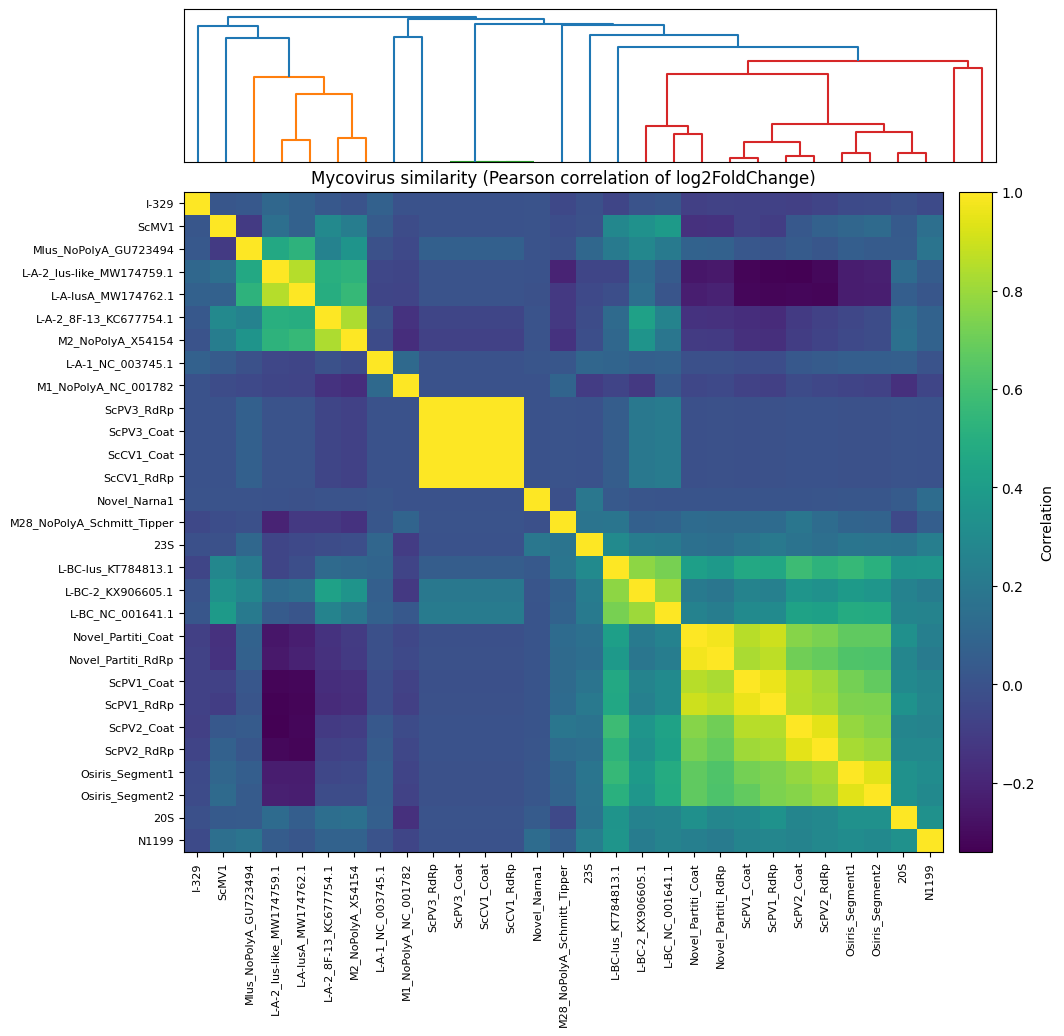

[✓] Saved heatmaps → mycovirus_log2FC_corr_heatmap.png, mycovirus_log2FC_corr_heatmap.pdf
[i] Files included (29): I-329, ScMV1, Mlus_NoPolyA_GU723494, L-A-2_lus-like_MW174759.1, L-A-lusA_MW174762.1, L-A-2_8F-13_KC677754.1, M2_NoPolyA_X54154, L-A-1_NC_003745.1, M1_NoPolyA_NC_001782, ScPV3_RdRp, ScPV3_Coat, ScCV1_Coat, ScCV1_RdRp, Novel_Narna1, M28_NoPolyA_Schmitt_Tipper, 23S, L-BC-lus_KT784813.1, L-BC-2_KX906605.1, L-BC_NC_001641.1, Novel_Partiti_Coat, Novel_Partiti_RdRp, ScPV1_Coat, ScPV1_RdRp, ScPV2_Coat, ScPV2_RdRp, Osiris_Segment1, Osiris_Segment2, 20S, N1199


In [22]:
# JUPYTER CELL — log2FC similarity across mycovirus DEG profiles (hierarchical heatmap)
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SciPy is optional but recommended for clustering; without it we just sort by mean corr
try:
    from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
    from scipy.spatial.distance import squareform
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# -----------------------
# Config (edit as needed)
# -----------------------
DEG_DIR        = Path("data/DEG")
FILE_GLOB      = "DEG_*_vs_Rest.csv"       # pattern of DEG result files
MIN_OVERLAP    = 5                         # min overlapping genes to compute a pairwise correlation
OUT_CORR_TSV   = DEG_DIR / "mycovirus_log2FC_correlation.tsv"
OUT_HEATMAP_PNG= DEG_DIR / "mycovirus_log2FC_corr_heatmap.png"
OUT_HEATMAP_PDF= DEG_DIR / "mycovirus_log2FC_corr_heatmap.pdf"

# -----------------------
# Helpers
# -----------------------
def detect_delim(path: Path) -> str:
    """Heuristic delimiter detection (tab vs comma)."""
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        head = f.readline()
    return "\t" if (head.count("\t") >= head.count(",")) else ","

def label_from_path(p: Path) -> str:
    """Extract a clean virus label from filename like 'DEG_<virus>_vs_Rest.csv'."""
    stem = p.stem
    if stem.startswith("DEG_") and stem.endswith("_vs_Rest"):
        return stem[len("DEG_"):-len("_vs_Rest")]
    return stem

def load_log2fc_series(p: Path) -> pd.Series:
    """Load a single DEG file → Series indexed by gene, values = log2FoldChange."""
    sep = detect_delim(p)
    df = pd.read_csv(p, sep=sep)
    cols = {c.strip(): c for c in df.columns}
    if "gene" not in cols or "log2FoldChange" not in cols:
        raise ValueError(f"{p.name}: missing required columns 'gene' and/or 'log2FoldChange'")
    s = df[["gene", "log2FoldChange"]].copy()
    s["gene"] = s["gene"].astype(str).str.strip()
    s = s.dropna(subset=["gene"])
    # Convert to numeric safely
    s["log2FoldChange"] = pd.to_numeric(s["log2FoldChange"], errors="coerce")
    s = s.dropna(subset=["log2FoldChange"])
    s = s.drop_duplicates(subset=["gene"], keep="first")
    return pd.Series(s["log2FoldChange"].values, index=s["gene"].values, name=label_from_path(p))

# -----------------------
# Load all DEG files
# -----------------------
files = sorted(DEG_DIR.glob(FILE_GLOB))
if not files:
    raise SystemExit(f"[error] No files matching {DEG_DIR / FILE_GLOB}")

series_list = []
for f in files:
    try:
        series_list.append(load_log2fc_series(f))
    except Exception as e:
        print(f"[warn] Skipping {f.name}: {e}")

if not series_list:
    raise SystemExit("[error] No valid DEG files loaded.")

# Union by gene; columns are viruses
log2fc = pd.concat(series_list, axis=1)
log2fc.replace([np.inf, -np.inf], np.nan, inplace=True)

# Pairwise Pearson correlation with pairwise-complete observations
corr = log2fc.corr(method="pearson", min_periods=MIN_OVERLAP)
# For pairs with < MIN_OVERLAP, corr = NaN → set to 0 (neutral similarity)
corr = corr.fillna(0.0)

# Save correlation matrix
corr.to_csv(OUT_CORR_TSV, sep="\t")
print(f"[✓] Saved correlation matrix → {OUT_CORR_TSV}")

# -----------------------
# Cluster & plot heatmap
# -----------------------
labels = corr.index.tolist()
mat = corr.values

# Distance = 1 - corr, clipped to [0, 2], symmetrized
dist = 1.0 - mat
dist[dist < 0] = 0.0
dist = (dist + dist.T) / 2.0

if SCIPY_OK and len(labels) > 2:
    # Condensed distance for linkage; average linkage (UPGMA)
    condensed = squareform(dist, checks=False)
    Z = linkage(condensed, method="average")
    order = leaves_list(Z)
else:
    # Fallback: order by mean correlation
    order = np.argsort(-mat.mean(axis=1))

ordered_labels = [labels[i] for i in order]
ordered_corr   = mat[order][:, order]

# Figure with dendrogram on top and heatmap below
fig = plt.figure(figsize=(max(10, len(labels)*0.35), max(8, len(labels)*0.35)))

# Dendrogram (top)
if SCIPY_OK and len(labels) > 2:
    ax_d = fig.add_axes([0.10, 0.80, 0.80, 0.15])  # [left,bottom,width,height]
    dendrogram(Z, labels=[labels[i] for i in order], no_labels=True, ax=ax_d, color_threshold=None)
    ax_d.set_xticks([]); ax_d.set_yticks([])
else:
    ax_d = fig.add_axes([0.10, 0.80, 0.80, 0.15]); ax_d.axis("off")

# Heatmap
ax_h = fig.add_axes([0.10, 0.12, 0.80, 0.65])
im = ax_h.imshow(ordered_corr, aspect="auto", interpolation="nearest")
ax_h.set_xticks(range(len(ordered_labels)))
ax_h.set_xticklabels(ordered_labels, rotation=90, fontsize=8)
ax_h.set_yticks(range(len(ordered_labels)))
ax_h.set_yticklabels(ordered_labels, fontsize=8)
ax_h.set_title("Mycovirus similarity (Pearson correlation of log2FoldChange)")
cbar = fig.colorbar(im, ax=ax_h, fraction=0.046, pad=0.02)
cbar.set_label("Correlation")

fig.tight_layout()

fig.savefig(OUT_HEATMAP_PNG, dpi=200, bbox_inches="tight")
fig.savefig(OUT_HEATMAP_PDF, bbox_inches="tight")
plt.show()

print(f"[✓] Saved heatmaps → {OUT_HEATMAP_PNG.name}, {OUT_HEATMAP_PDF.name}")
print(f"[i] Files included ({len(ordered_labels)}): {', '.join(ordered_labels)}")

[✓] wrote matrix → data/enrichment/GOxVirus_signed_scores.tsv  shape=(240, 29)


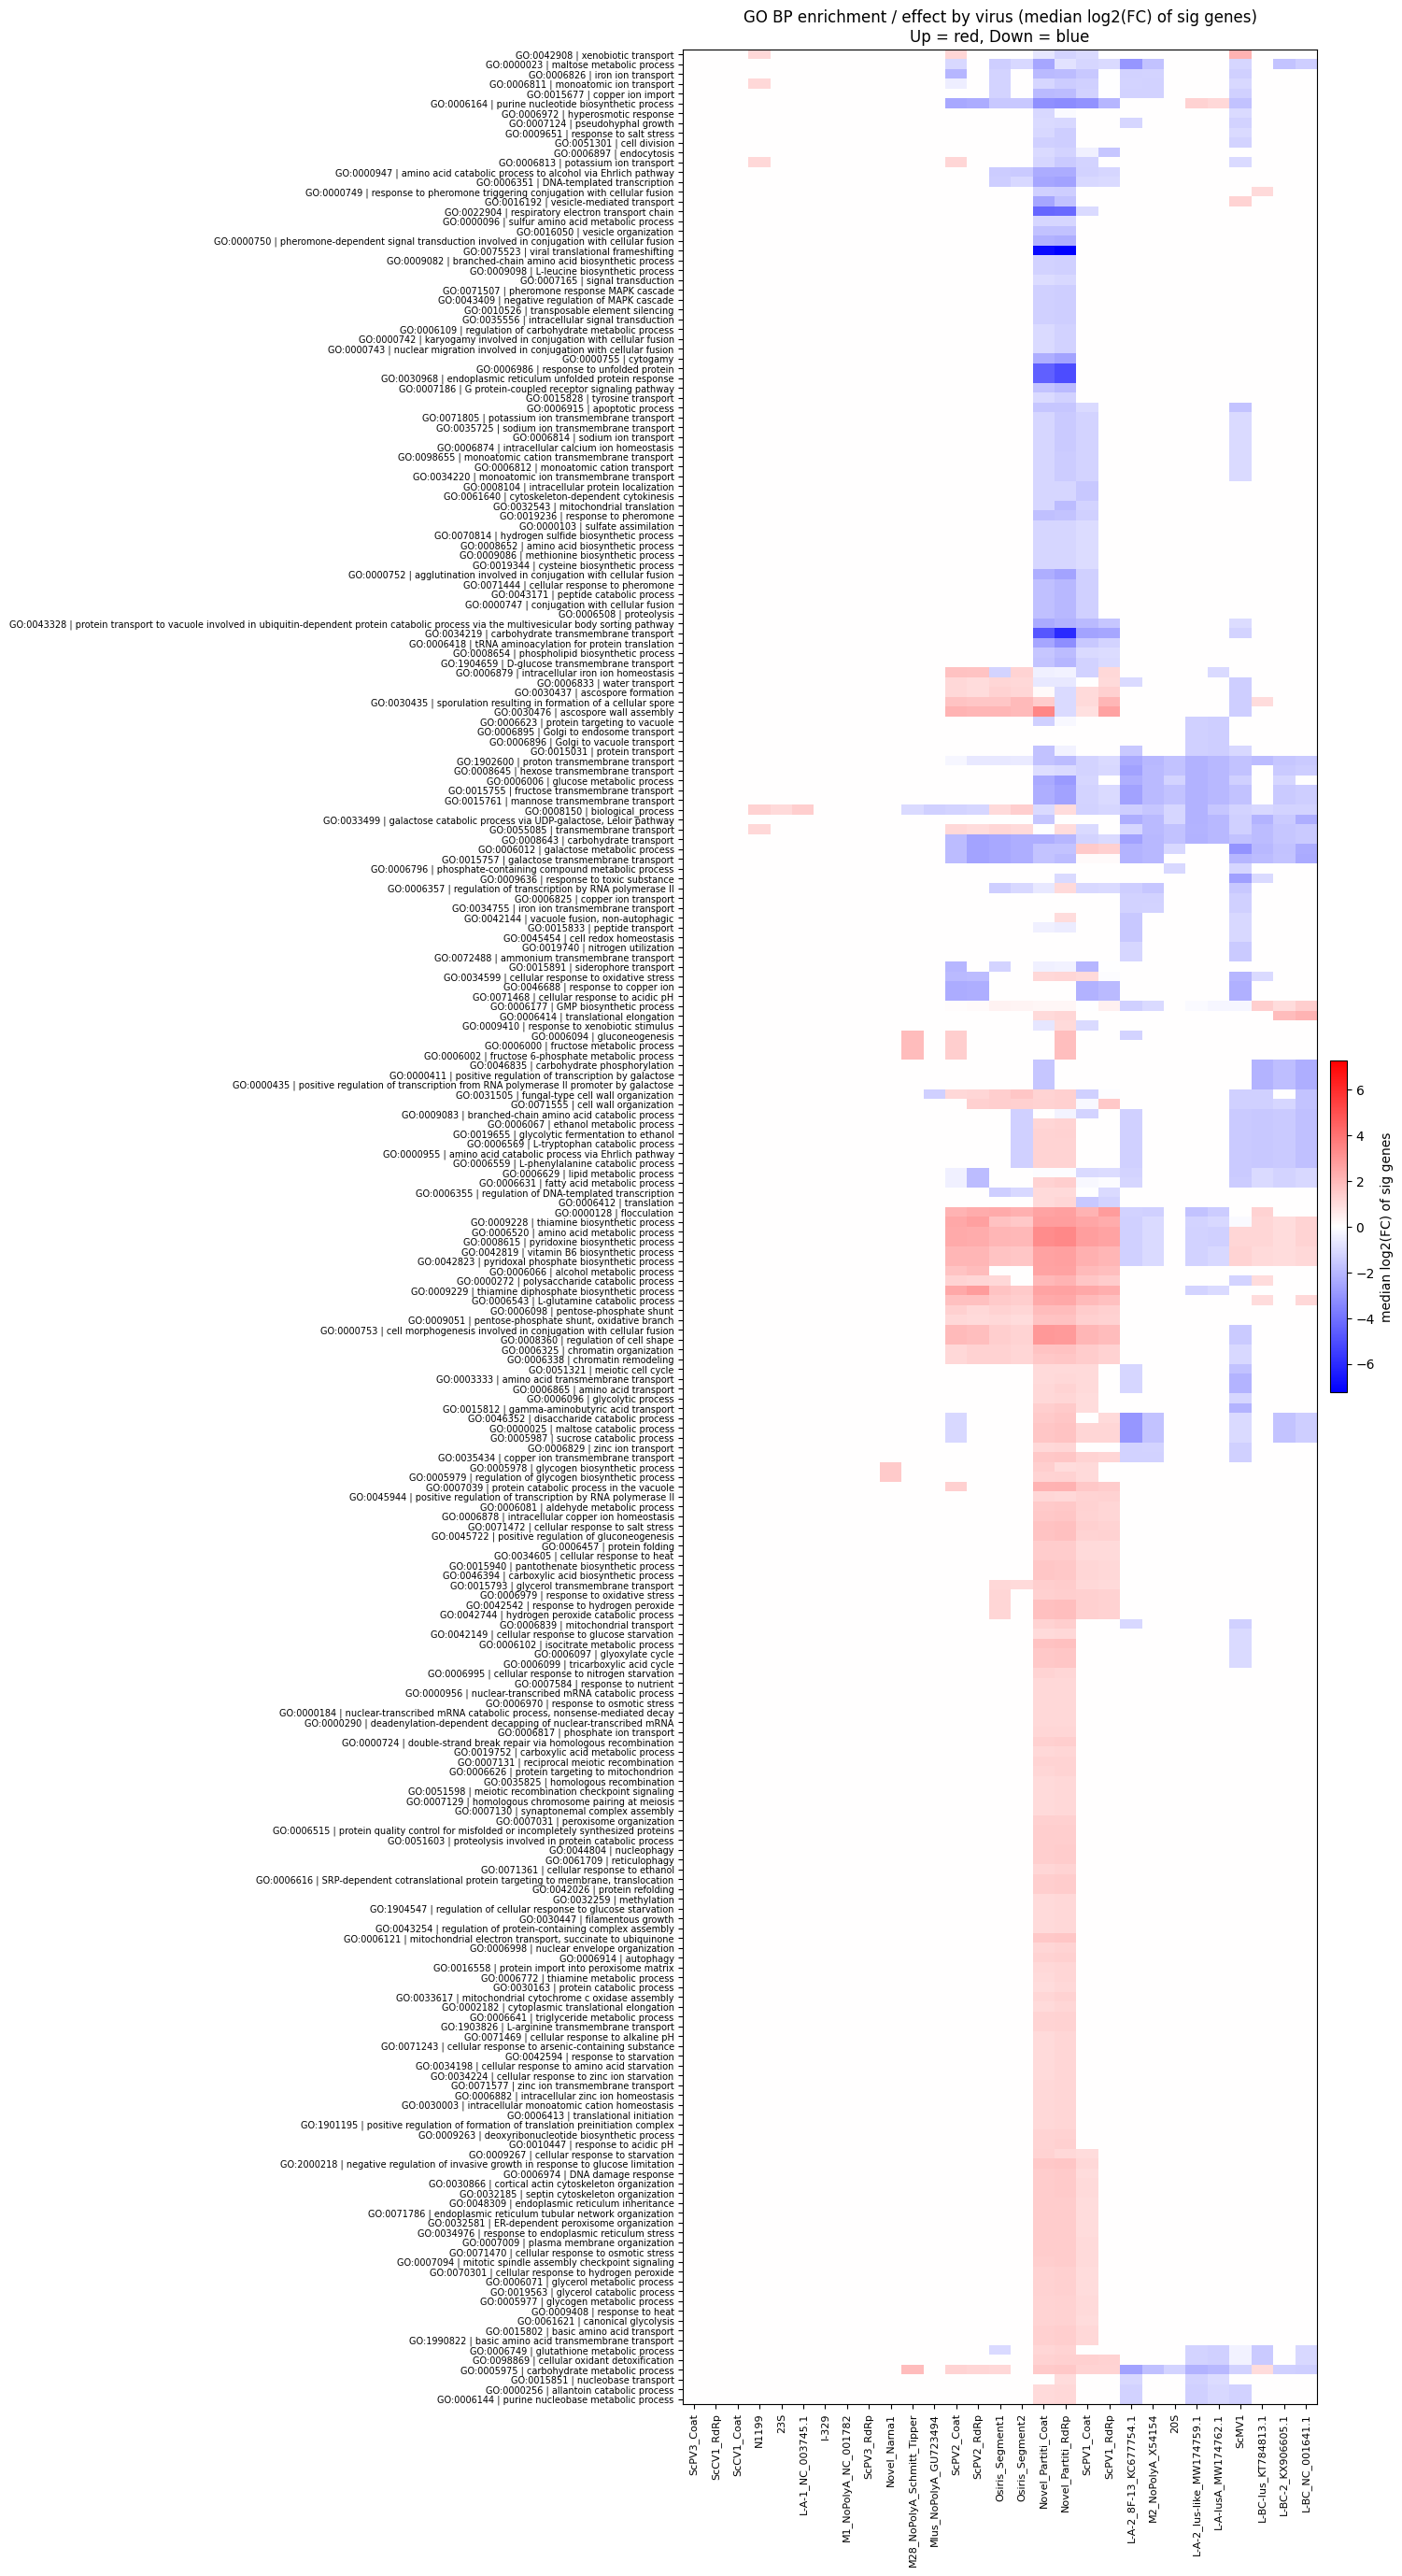

[✓] wrote heatmap → GOxVirus_signed_scores_heatmap.png, GOxVirus_signed_scores_heatmap.pdf


In [157]:
# JUPYTER CELL — Batch GO BP ORA → signed GO×virus heatmap (FDR or log2FC coloring)
from pathlib import Path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

try:
    from scipy.cluster.hierarchy import linkage, leaves_list
    from scipy.spatial.distance import squareform
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# -----------------------
# Config
# -----------------------
GO_JSON_PATH = Path("data/annotations/go_bp.json")
DEG_DIR      = Path("data/DEG")
DEG_GLOB     = "DEG_*_vs_Rest.csv"
OUT_DIR      = Path("data/enrichment")
MATRIX_TSV   = OUT_DIR / "GOxVirus_signed_scores.tsv"
HEAT_PNG     = OUT_DIR / "GOxVirus_signed_scores_heatmap.png"
HEAT_PDF     = OUT_DIR / "GOxVirus_signed_scores_heatmap.pdf"

COLOR_MODE        = "logfc"   # "fdr" or "logfc"
FDR_EPS           = 1e-300
MIN_SET_SIZE      = 5
MAX_SET_SIZE      = 2000
SIG_FDR           = 0.05 if COLOR_MODE == "logfc" else 0.05
SIG_LOGFC         = 1 if COLOR_MODE == "logfc" else 0     # absolute median log2FC threshold when COLOR_MODE=="logfc"
MIN_SIG_VIRUSES   = 2
TOP_TERMS         = None     # e.g., 300

OUT_DIR.mkdir(parents=True, exist_ok=True)

def virus_label_from_path(p: Path) -> str:
    s = p.stem
    return s[len("DEG_"):-len("_vs_Rest")] if (s.startswith("DEG_") and s.endswith("_vs_Rest")) else s

def detect_delim(p: Path) -> str:
    with open(p, "r", encoding="utf-8", errors="replace") as f:
        first = f.readline()
    return "\t" if first.count("\t") >= first.count(",") else ","

def read_go_bp(path: Path):
    d = json.loads(path.read_text(encoding="utf-8"))
    # standardize structure
    go = {}
    for goid, v in d.items():
        name = v.get("name", v.get("term", goid))
        genes = sorted({str(g).strip() for g in v.get("genes", []) if g})
        if MIN_SET_SIZE <= len(genes) <= MAX_SET_SIZE:
            go[goid] = {"name": name, "genes": genes}
    return go

go = read_go_bp(GO_JSON_PATH)

# -----------------------
# Collect tidy rows per virus
# -----------------------
files = sorted(DEG_DIR.glob(DEG_GLOB))
if not files:
    raise SystemExit(f"[error] No files matching {DEG_DIR / DEG_GLOB}")

tidy_rows = []

for fp in files:
    virus = virus_label_from_path(fp)
    sep = detect_delim(fp)
    deg = pd.read_csv(fp, sep=sep, low_memory=False)
    # basic columns
    for c in ("gene","log2FoldChange","padj","sig"):
        if c not in deg.columns:
            raise SystemExit(f"[error] {fp.name} missing required column '{c}'")

    # normalize types
    deg["gene"] = deg["gene"].astype(str).str.strip()
    deg["log2FoldChange"] = pd.to_numeric(deg["log2FoldChange"], errors="coerce")
    deg["padj"] = pd.to_numeric(deg["padj"], errors="coerce")
    deg["sig_bool"] = (deg["sig"].astype(str).str.upper().isin(["TRUE","T","1","YES"]))
    deg = deg.dropna(subset=["gene","log2FoldChange","padj"])

    # universe = genes present in GO
    go_genes = {g for v in go.values() for g in v["genes"]}
    universe_mask = deg["gene"].isin(go_genes)
    deg_u = deg[universe_mask].copy()
    if deg_u.empty:
        print(f"[warn] {virus}: no genes in DEG intersect GO universe; skipping")
        continue

    if COLOR_MODE == "fdr":
        # Use your existing enrichment function to get per-term FDR (Up/Down)
        up_df, down_df = enrich_from_paths(GO_JSON_PATH, fp, min_set=MIN_SET_SIZE, max_set=MAX_SET_SIZE, out_dir=None)
        # Build signed score (+ for Up, - for Down)
        pack = []
        if not up_df.empty:
            x = up_df[["go_id","name","fdr"]].copy()
            x["signed_score"] = -np.log10(x["fdr"].clip(lower=FDR_EPS))
            x["virus"] = virus
            pack.append(x)
        if not down_df.empty:
            x = down_df[["go_id","name","fdr"]].copy()
            x["signed_score"] = -np.log10(x["fdr"].clip(lower=FDR_EPS)) * (-1.0)
            x["virus"] = virus
            pack.append(x)
        if not pack:
            print(f"[warn] {virus}: enrichment produced no rows")
            continue
        vtidy = pd.concat(pack, ignore_index=True)
        # Keep strongest direction per (virus, go_id)
        vtidy["abs_score"] = vtidy["signed_score"].abs()
        vtidy = vtidy.loc[vtidy.groupby(["virus","go_id"])["abs_score"].idxmax(), ["virus","go_id","name","signed_score","fdr"]]
        tidy_rows.append(vtidy)

    elif COLOR_MODE == "logfc":
        # Per-term median log2FC over **significant genes** (padj<SIG_FDR and |log2FC|≥SIG_LOGFC)
        sig_mask = (deg_u["padj"] < SIG_FDR) & (deg_u["log2FoldChange"].abs() >= SIG_LOGFC)
        deg_sig = deg_u[sig_mask]
        # If none significant, we still compute medians as 0 (or skip)
        data = []
        for goid, entry in go.items():
            term_genes = set(entry["genes"])
            g = deg_sig[deg_sig["gene"].isin(term_genes)]
            if g.empty:
                score = 0.0
                term_fdr = 1.0
            else:
                score = float(np.median(g["log2FoldChange"].values))
                # synthesize a "term fdr" proxy just for filtering/diagnostics (min gene-wise)
                term_fdr = float(np.nanmin(g["padj"].values))
            data.append((virus, goid, entry["name"], score, term_fdr))
        vtidy = pd.DataFrame(data, columns=["virus","go_id","name","signed_score","fdr"])
        # Optionally drop terms with empty universe contribution (all zeros)
        tidy_rows.append(vtidy)

    else:
        raise ValueError(f"Invalid COLOR_MODE: {COLOR_MODE}")

tidy = pd.concat(tidy_rows, ignore_index=True)
if tidy.empty:
    raise SystemExit("[error] No tidy rows produced; check inputs.")

# -----------------------
# Row pruning by metric
# -----------------------
if COLOR_MODE == "fdr":
    # significant if fdr < SIG_FDR
    sig_mask = tidy["fdr"] < SIG_FDR
else:  # logfc
    sig_mask = tidy["signed_score"].abs() >= SIG_LOGFC

keep_terms = (
    tidy.loc[sig_mask]
        .groupby("go_id")["virus"]
        .nunique()
        .pipe(lambda s: s[s >= MIN_SIG_VIRUSES].index)
)
tidy = tidy[tidy["go_id"].isin(keep_terms)]

# Merge any duplicates (should be none after above, but safe): keep max |score|
tidy["abs_score"] = tidy["signed_score"].abs()
idx = tidy.groupby(["virus","go_id"])["abs_score"].idxmax()
tidy_merged = tidy.loc[idx, ["virus","go_id","name","signed_score"]].copy()

# -----------------------
# Build matrix
# -----------------------
tidy_merged["row_label"] = tidy_merged["go_id"] + " | " + tidy_merged["name"].astype(str)
mat = tidy_merged.pivot_table(index="row_label", columns="virus", values="signed_score", aggfunc="first").fillna(0.0)

if TOP_TERMS is not None and mat.shape[0] > TOP_TERMS:
    keep_idx = np.argsort(-mat.abs().max(axis=1).values)[:TOP_TERMS]
    mat = mat.iloc[keep_idx]

mat.to_csv(MATRIX_TSV, sep="\t")
print(f"[✓] wrote matrix → {MATRIX_TSV}  shape={mat.shape}")

# -----------------------
# Cluster + plot
# -----------------------
def order_by_corr(M: np.ndarray):
    X = M.copy()
    X = X - X.mean(axis=1, keepdims=True)
    denom = np.linalg.norm(X, axis=1, keepdims=True); denom[denom==0]=1.0
    Z = X/denom
    corr = (Z @ Z.T) / (Z.shape[1] if Z.shape[1] > 1 else 1)
    dist = 1 - np.clip(corr, -1, 1)
    dist = (dist + dist.T)/2
    if SCIPY_OK and M.shape[0] > 2:
        Zlink = linkage(squareform(dist, checks=False), method="average")
        return leaves_list(Zlink)
    return np.argsort(dist.mean(axis=1))

row_order = order_by_corr(mat.values)
col_order = order_by_corr(mat.values.T)
M = mat.values[row_order][:, col_order]
row_labels = [mat.index[i] for i in row_order]
col_labels = [mat.columns[j] for j in col_order]

fig = plt.figure(figsize=(max(10, len(col_labels)*0.35), max(20, len(row_labels)*0.1 + 4)))
ax = fig.add_axes([0.15, 0.05, 0.70, 0.90])
vmax = float(np.nanmax(np.abs(M))) if M.size else 1.0
im = ax.imshow(M, aspect="auto", interpolation="nearest", cmap="bwr", vmin=-vmax, vmax=vmax)
ax.set_xticks(range(len(col_labels))); ax.set_xticklabels(col_labels, rotation=90, fontsize=8)
ax.set_yticks(range(len(row_labels))); ax.set_yticklabels(row_labels, fontsize=7)

title_metric = "signed -log10(FDR)" if COLOR_MODE == "fdr" \
               else "median log2(FC) of sig genes"
ax.set_title(f"GO BP enrichment / effect by virus ({title_metric})\nUp = red, Down = blue")
cbar = fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label(title_metric)

fig.savefig(HEAT_PNG, dpi=200, bbox_inches="tight")
fig.savefig(HEAT_PDF, bbox_inches="tight")
plt.show()
print(f"[✓] wrote heatmap → {HEAT_PNG.name}, {HEAT_PDF.name}")

In [134]:
# JUPYTER CELL — Rebuild heatmap with unified filtering + signed log compression (FDR or log2FC)
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.cluster.hierarchy import linkage, leaves_list
    from scipy.spatial.distance import squareform
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# -----------------------
# Config
# -----------------------
COLOR_MODE       = "logfc"   # "fdr" for signed -log10(FDR), "logfc" for median log2FC
MATRIX_TSV       = Path("data/enrichment/GOxVirus_signed_scores.tsv")  # matrix produced by your batch step
OUT_DIR          = Path("data/enrichment")
SIG_FDR          = 1 if COLOR_MODE == "logfc" else 0.05
SIG_LOGFC        = 0 if COLOR_MODE == "logfc" else 0     # absolute median log2FC threshold when COLOR_MODE=="logfc"
MIN_SIG_VIRUSES  = 2       # require at least this many significant columns in a row to keep it
TOP_TERMS        = None    # e.g., 300 to cap height; None keeps all

# Output files (auto-suffixed by mode)
suffix = "FDR" if COLOR_MODE.lower() == "fdr" else "logFC"
HEAT_PNG = OUT_DIR / f"GOxVirus_signed_scores_sigOnly_{suffix}.png"
HEAT_PDF = OUT_DIR / f"GOxVirus_signed_scores_sigOnly_{suffix}.pdf"

# -----------------------
# Load
# -----------------------
mat = pd.read_csv(MATRIX_TSV, sep="\t", index_col=0)
if mat.empty:
    raise SystemExit(f"[error] matrix empty: {MATRIX_TSV}")

# -----------------------
# Prune rows based on significance in ≥ MIN_SIG_VIRUSES columns
# -----------------------
if COLOR_MODE.lower() == "fdr":
    thr_val = -np.log10(SIG_FDR)  # matrix stores signed -log10(FDR)
    sig_mask = (mat.abs() >= thr_val)
    keep_label = f"FDR<{SIG_FDR}"
    cbar_label = "signed log₂(1+|-log10(FDR)|)"
    title_metric = "signed -log10(FDR)"
else:
    thr_val = float(SIG_LOGFC)    # matrix stores signed/median log2FC
    sig_mask = (mat.abs() >= thr_val)
    keep_label = f"|log2FC|≥{SIG_LOGFC:g}"
    cbar_label = "signed log₂(1+|log2FC|)"
    title_metric = "median log2(FC) of sig genes"

row_keep = sig_mask.sum(axis=1) >= int(MIN_SIG_VIRUSES)
mat = mat.loc[row_keep]
print(f"[i] kept {mat.shape[0]} GO terms after pruning at {keep_label} "
      f"and ≥{MIN_SIG_VIRUSES} virus(es)")

# Optional height cap by informativeness
if TOP_TERMS is not None and mat.shape[0] > TOP_TERMS:
    keep_idx = np.argsort(-mat.abs().max(axis=1).values)[:TOP_TERMS]
    mat = mat.iloc[keep_idx]

if mat.shape[0] == 0:
    raise SystemExit("[error] no rows remain after pruning; relax thresholds?")

# -----------------------
# Order rows and columns by correlation distance (hierarchical)
# -----------------------
def leaves_by_corr(Mdf: pd.DataFrame):
    """Return leaf order from average-linkage clustering on (1 - Pearson corr) distance."""
    X = Mdf.values
    # normalize rows
    Xc = X - X.mean(axis=1, keepdims=True)
    denom = np.linalg.norm(Xc, axis=1, keepdims=True); denom[denom == 0] = 1.0
    Z = Xc / denom
    # row-wise correlation matrix
    corr = (Z @ Z.T) / (Z.shape[1] if Z.shape[1] > 1 else 1)
    dist = 1 - np.clip(corr, -1, 1)
    dist = (dist + dist.T) / 2.0
    if SCIPY_OK and Mdf.shape[0] > 2:
        Zlink = linkage(squareform(dist, checks=False), method="average")
        return leaves_list(Zlink)
    # fallback: sort by mean distance
    return np.argsort(dist.mean(axis=1))

# row clustering
row_order = leaves_by_corr(mat)
mat = mat.iloc[row_order]

# column clustering (apply same logic to transposed matrix)
col_order = leaves_by_corr(mat.T)
mat = mat.iloc[:, col_order]

# -----------------------
# Signed log compression (keeps sign, compresses magnitude)
# -----------------------
def signed_log_compress(arr, base=2.0):
    return np.sign(arr) * (np.log1p(np.abs(arr)) / np.log(base))

mat_plot = pd.DataFrame(
    signed_log_compress(mat.values, base=2.0),
    index=mat.index.copy(),
    columns=mat.columns.copy()
)

# -----------------------
# Plot
# -----------------------
OUT_DIR.mkdir(parents=True, exist_ok=True)
vmax = float(np.nanmax(np.abs(mat_plot.values))) if mat_plot.size else 1.0

fig = plt.figure(figsize=(max(10, mat_plot.shape[1]*0.35), max(16, mat_plot.shape[0]*0.15 + 4)))
ax = fig.add_axes([0.15, 0.05, 0.70, 0.90])

im = ax.imshow(mat_plot.values, aspect="auto", interpolation="nearest", cmap="bwr",
               vmin=-vmax, vmax=vmax)

ax.set_xticks(range(mat_plot.shape[1]))
ax.set_xticklabels(mat_plot.columns, rotation=90, fontsize=10)
ax.set_yticks(range(mat_plot.shape[0]))
ax.set_yticklabels(mat_plot.index, fontsize=8)

ax.set_title(
    f"GO BP enrichment/effect (clustered) — {title_metric}\n"
    f"Rows require ≥{MIN_SIG_VIRUSES} cell(s) with {keep_label}"
)
cbar = fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label(cbar_label)

fig.savefig(HEAT_PNG, dpi=200, bbox_inches="tight")
fig.savefig(HEAT_PDF, bbox_inches="tight")
plt.show()

print(f"[✓] wrote: {HEAT_PNG.name}, {HEAT_PDF.name}")

In [126]:
# # JUPYTER CELL — rebuild heatmap but drop GO terms with no significant cells anywhere
# from pathlib import Path
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# try:
#     from scipy.cluster.hierarchy import linkage, leaves_list
#     from scipy.spatial.distance import squareform
#     SCIPY_OK = True
# except Exception:
#     SCIPY_OK = False

# MATRIX_TSV = Path("data/enrichment/GOxVirus_signed_scores.tsv")  # produced by previous cell
# HEAT_PNG   = Path("data/enrichment/GOxVirus_signed_scores_sigOnly.png")
# HEAT_PDF   = Path("data/enrichment/GOxVirus_signed_scores_sigOnly.pdf")

# SIG_FDR          = 1     # significance for pruning rows
# MIN_SIG_VIRUSES  = 2        # require at least this many viruses with FDR < SIG_FDR in a row
# TOP_TERMS        = None     # optionally cap height, e.g., 300

# mat = pd.read_csv(MATRIX_TSV, sep="\t", index_col=0)

# # threshold in signed-score space
# thr = -np.log10(SIG_FDR)
# sig_mask = (mat.abs() >= thr)
# row_keep = sig_mask.sum(axis=1) >= MIN_SIG_VIRUSES
# mat = mat.loc[row_keep]

# if TOP_TERMS is not None and mat.shape[0] > TOP_TERMS:
#     # keep most informative rows by max abs score
#     keep_idx = np.argsort(-mat.abs().max(axis=1).values)[:TOP_TERMS]
#     mat = mat.iloc[keep_idx]

# print(f"[i] kept {mat.shape[0]} GO terms after pruning at FDR<{SIG_FDR} "
#       f"and ≥{MIN_SIG_VIRUSES} sig virus(es)")

# # --- cluster ---
# def order_corr(M):
#     X = M.values
#     # correlation distance
#     Xc = X - X.mean(axis=1, keepdims=True)
#     denom = np.linalg.norm(Xc, axis=1, keepdims=True); denom[denom==0]=1.0
#     Z = Xc/denom
#     corr = (Z @ Z.T) / (Z.shape[1] if Z.shape[1] > 1 else 1)
#     dist = 1 - np.clip(corr, -1, 1)
#     dist = (dist + dist.T)/2
#     if SCIPY_OK and M.shape[0] > 2:
#         Zlink = linkage(squareform(dist, checks=False), method="average")
#         order = leaves_list(Zlink)
#     else:
#         order = np.argsort(dist.mean(axis=1))
#     return M.iloc[order]

# mat_ord_rows = order_corr(mat)
# mat_ord = order_corr(mat_ord_rows.T).T  # order columns the same way

# # --- plot ---
# vmax = float(np.nanmax(np.abs(mat_ord.values))) if mat_ord.size else 1.0
# fig = plt.figure(figsize=(max(10, mat_ord.shape[1]*0.35), max(16, mat_ord.shape[0]*0.03 + 4)))
# ax = fig.add_axes([0.15, 0.05, 0.70, 0.90])
# im = ax.imshow(mat_ord.values, aspect="auto", interpolation="nearest", cmap="bwr",
#                vmin=-vmax, vmax=vmax)
# ax.set_xticks(range(mat_ord.shape[1]))
# ax.set_xticklabels(mat_ord.columns, rotation=90, fontsize=10)
# ax.set_yticks(range(mat_ord.shape[0]))
# ax.set_yticklabels(mat_ord.index, fontsize=8)
# ax.set_title(f"GO BP enrichment (signed -log10 FDR)\nRows require ≥{MIN_SIG_VIRUSES} cell(s) with FDR<{SIG_FDR}")
# cbar = fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02)

# # Apply signed log transform to compress outliers but keep direction
# def signed_log(x, base=2):
#     return np.sign(x) * np.log1p(np.abs(x)) / np.log(base)

# # Transform before plotting
# mat_plot = mat_ord.copy()
# mat_plot[:] = signed_log(mat_ord.values, base=2)

# vmax = np.nanmax(np.abs(mat_plot.values)) if mat_plot.size else 1.0
# im = ax.imshow(mat_plot.values, aspect="auto", interpolation="nearest", cmap="bwr",
#                vmin=-vmax, vmax=vmax)
# cbar.set_label("signed log₂(1+|-log10FDR|)")

# fig.savefig(HEAT_PNG, dpi=200, bbox_inches="tight")
# fig.savefig(HEAT_PDF, bbox_inches="tight")
# plt.show()

# print(f"[✓] wrote: {HEAT_PNG.name}, {HEAT_PDF.name}")

[✓] 20S: up(sig)=   0  down(sig)=   6  labeled= 6  → volcano_20S.png
[✓] 23S: up(sig)=   1  down(sig)=   0  labeled= 1  → volcano_23S.png
[warn] skipping DEG_I-329_vs_Rest.csv: zero-size array to reduction operation fmax which has no identity
[✓] L-A-1_NC_003745.1: up(sig)=   3  down(sig)=   0  labeled= 3  → volcano_L-A-1_NC_003745.1.png
[✓] L-A-2_8F-13_KC677754.1: up(sig)=   1  down(sig)=  32  labeled=30  → volcano_L-A-2_8F-13_KC677754.1.png
[✓] L-A-2_lus-like_MW174759.1: up(sig)=   3  down(sig)=  13  labeled=16  → volcano_L-A-2_lus-like_MW174759.1.png
[✓] L-A-lusA_MW174762.1: up(sig)=   2  down(sig)=  21  labeled=23  → volcano_L-A-lusA_MW174762.1.png
[✓] L-BC-2_KX906605.1: up(sig)=   4  down(sig)=  15  labeled=19  → volcano_L-BC-2_KX906605.1.png
[✓] L-BC-lus_KT784813.1: up(sig)=  11  down(sig)=  11  labeled=22  → volcano_L-BC-lus_KT784813.1.png
[✓] L-BC_NC_001641.1: up(sig)=   6  down(sig)=  13  labeled=19  → volcano_L-BC_NC_001641.1.png
[warn] skipping DEG_M1_NoPolyA_NC_001782_vs_Re

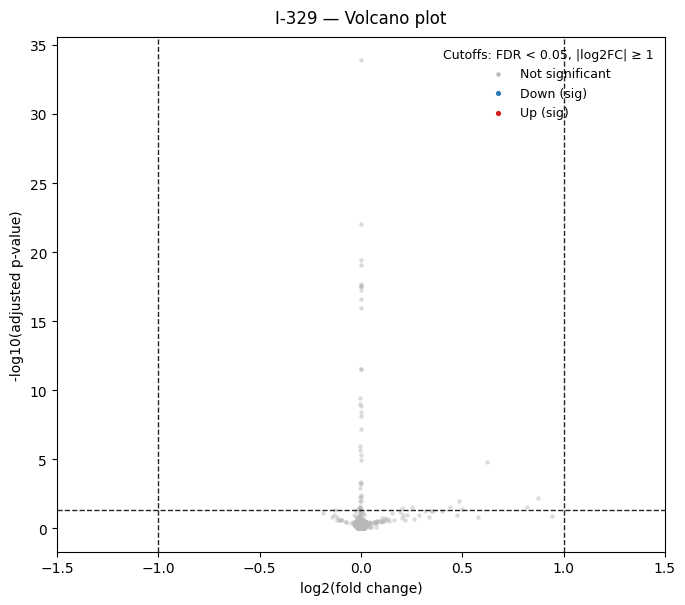

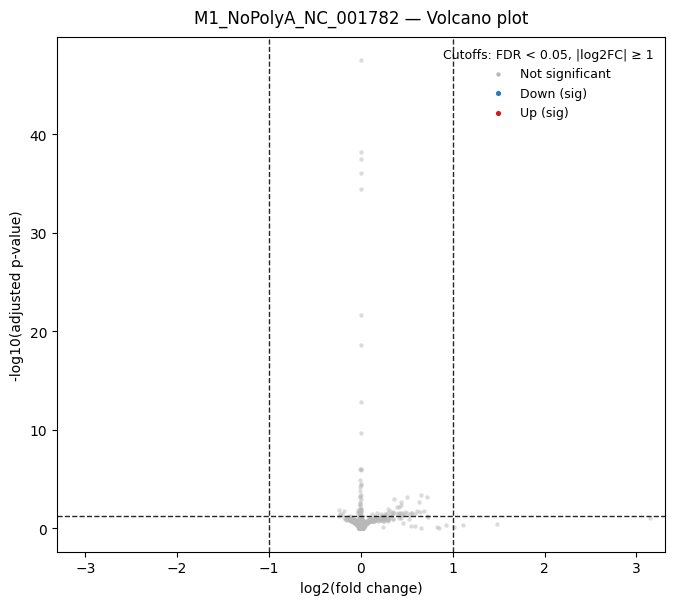

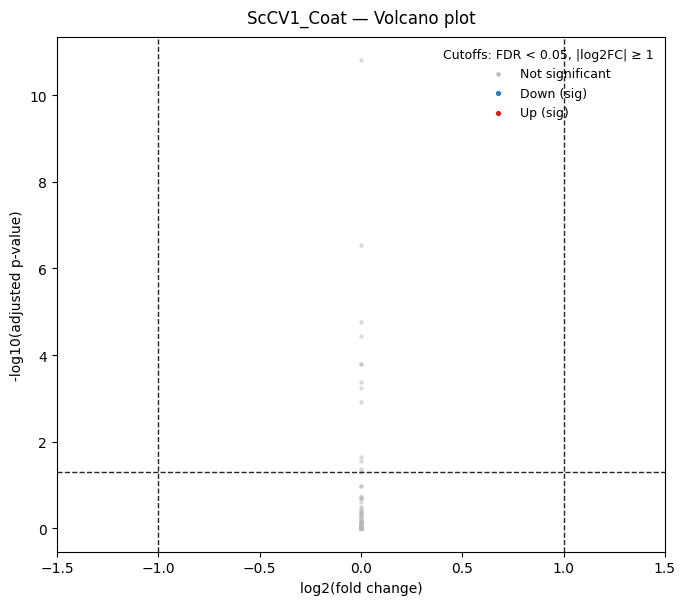

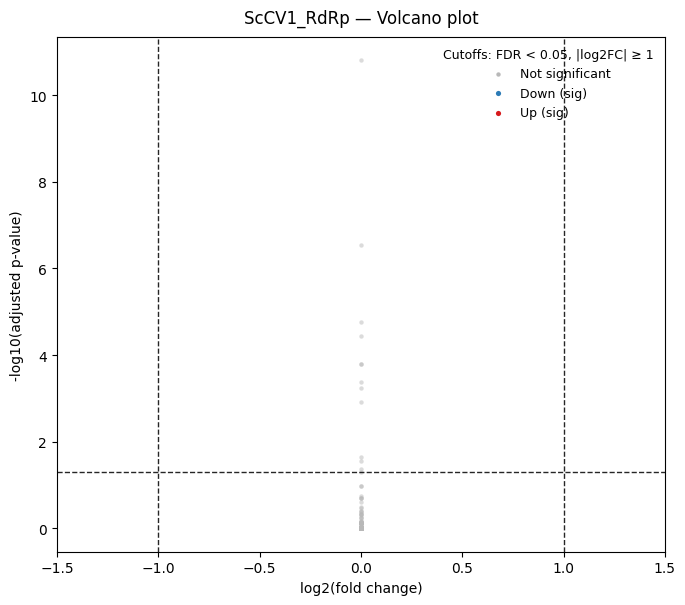

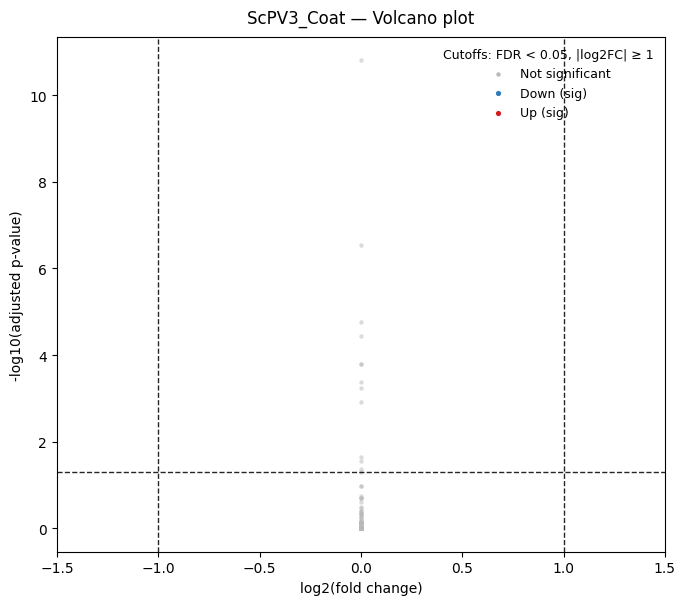

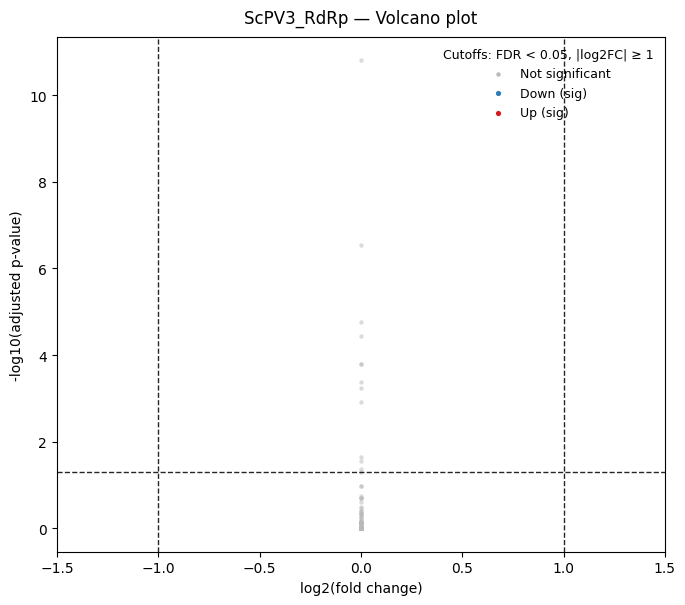

In [65]:
# JUPYTER CELL — Volcano plots for each mycovirus DEG (labels w/ jitter + legend cutoffs)
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# Config (edit as needed)
# -----------------------
DEG_DIR        = Path("data/DEG")
DEG_GLOB       = "DEG_*_vs_Rest.csv"
SYS_STD_JSON   = Path("data/sys_gene_to_std_gene_map.json")
OUT_DIR        = Path("data/plots/volcano")
SIG_FDR        = 0.05              # dotted horizontal threshold
LFC_THRESH     = 1.0               # vertical thresholds; set to 2.0 if you prefer
TOP_LABELS     = 30                # label at most this many significant genes per plot
DPI            = 200               # PNG resolution
LABEL_FONTSIZE = 4.5               # smaller label font
JITTER_X       = 0.08              # horizontal jitter magnitude (log2FC units)
JITTER_Y       = 0.08              # vertical jitter magnitude (-log10 padj units)
MAX_PUSH_UP    = 0.6               # extra vertical nudge if many overlaps remain

OUT_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------
# Helpers
# -----------------------
def detect_delim(path: Path) -> str:
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        line = f.readline()
    return "\t" if line.count("\t") >= line.count(",") else ","

def deg_label_from_path(p: Path) -> str:
    stem = p.stem
    return stem[len("DEG_"):-len("_vs_Rest")] if (stem.startswith("DEG_") and stem.endswith("_vs_Rest")) else stem

def load_sys_to_std(path: Path) -> dict:
    try:
        return json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        print(f"[warn] sys→std mapping not found or unreadable at {path}; labels will use 'gene' as-is")
        return {}

def choose_labels(df_sig: pd.DataFrame, top_n: int) -> pd.DataFrame:
    """
    Pick top_n genes to label among significant hits:
    prioritize by highest -log10(padj), break ties by |log2FoldChange|.
    Balance up/down if possible.
    """
    if df_sig.empty or top_n <= 0:
        return df_sig.assign(to_label=False)
    scored = df_sig.copy()
    scored["_score"] = scored["neglog10padj"].values + 0.01*np.abs(scored["log2FoldChange"].values)
    half = max(1, top_n // 2)
    up_top = scored[scored["log2FoldChange"] >= 0].nlargest(half, "_score")
    down_top = scored[scored["log2FoldChange"] < 0].nlargest(top_n - len(up_top), "_score")
    idx = set(up_top.index).union(down_top.index)
    out = df_sig.copy()
    out["to_label"] = out.index.isin(idx)
    return out

def volcano_for_file(deg_file: Path, sys2std: dict):
    virus = deg_label_from_path(deg_file)
    sep = detect_delim(deg_file)
    df = pd.read_csv(deg_file, sep=sep)
    need_cols = {"gene", "log2FoldChange", "padj"}
    missing = need_cols - set(df.columns)
    if missing:
        raise ValueError(f"{deg_file.name} missing columns: {', '.join(sorted(missing))}")

    # Clean + axes
    df = df.copy()
    df["gene"] = df["gene"].astype(str).str.strip()
    df["log2FoldChange"] = pd.to_numeric(df["log2FoldChange"], errors="coerce")
    df["padj"] = pd.to_numeric(df["padj"], errors="coerce")
    df = df.dropna(subset=["gene", "log2FoldChange", "padj"])

    eps = 1e-300
    df["neglog10padj"] = -np.log10(np.clip(df["padj"].values, eps, 1.0))

    # Flags
    df["is_fdr"] = df["padj"] < SIG_FDR
    df["is_lfc"] = df["log2FoldChange"].abs() >= LFC_THRESH
    df["is_sig"] = df["is_fdr"] & df["is_lfc"]

    # Groups
    sig_up   = df[(df["is_sig"]) & (df["log2FoldChange"] > 0)]
    sig_down = df[(df["is_sig"]) & (df["log2FoldChange"] < 0)]
    not_sig  = df[~df["is_sig"]]

    # Label candidates
    sig_all = pd.concat([sig_up, sig_down]).sort_values("neglog10padj", ascending=False)
    sig_all = choose_labels(sig_all, TOP_LABELS)

    # Label text via sys→std map
    def pretty_label(sys_gene):
        std = sys2std.get(str(sys_gene))
        return f"{std} ({sys_gene})" if std and std != str(sys_gene) else str(sys_gene)

    # Figure
    fig = plt.figure(figsize=(7.6, 6.6))
    ax = fig.add_axes([0.12, 0.12, 0.80, 0.78])

    # Points
    ax.scatter(not_sig["log2FoldChange"], not_sig["neglog10padj"], s=10, c="#B8B8B8", alpha=0.5, linewidths=0, label="Not significant")
    ax.scatter(sig_down["log2FoldChange"], sig_down["neglog10padj"], s=14, c="#2C7BB6", alpha=0.85, linewidths=0, label="Down (sig)")
    ax.scatter(sig_up["log2FoldChange"],   sig_up["neglog10padj"],   s=14, c="#D7191C", alpha=0.85, linewidths=0, label="Up (sig)")

    # Threshold lines
    ax.axhline(-np.log10(SIG_FDR), color="black", linestyle="--", linewidth=1, alpha=0.85)
    ax.axvline(-LFC_THRESH, color="black", linestyle="--", linewidth=1, alpha=0.85)
    ax.axvline(+LFC_THRESH, color="black", linestyle="--", linewidth=1, alpha=0.85)

    # Legend with explicit cutoffs
    leg_text = f"Cutoffs: FDR < {SIG_FDR:g}, |log2FC| ≥ {LFC_THRESH:g}"
    leg = ax.legend(frameon=False, loc="upper right", fontsize=9, title=leg_text, title_fontsize=9)
    for lh in leg.legend_handles: lh.set_alpha(1.0)

    # Label jitter — deterministic per virus for reproducibility
    rng = np.random.RandomState(abs(hash(virus)) % (2**32))
    labeled_rows = sig_all[sig_all["to_label"]].copy()
    if not labeled_rows.empty:
        # Direction-aware base offset + random jitter
        base_x = np.where(labeled_rows["log2FoldChange"] >= 0, 0.04, -0.04)
        jitter_x = rng.uniform(-JITTER_X, JITTER_X, size=len(labeled_rows))
        jitter_y = rng.uniform(0.0, JITTER_Y, size=len(labeled_rows))

        # Prepare positions
        x_pos = labeled_rows["log2FoldChange"].to_numpy() + base_x + jitter_x
        y_pos = labeled_rows["neglog10padj"].to_numpy() + 0.18 + jitter_y

        # Minimal collision relief: if two labels share nearly same y, push the latter up a bit
        order = np.argsort(y_pos)
        for idx in order[1:]:
            close = np.isclose(y_pos[idx], y_pos[order], atol=0.15)
            if close.sum() > 2:
                y_pos[idx] += min(MAX_PUSH_UP, 0.08 * close.sum())

        for (x, y), (_, r) in zip(zip(x_pos, y_pos), labeled_rows.iterrows()):
            txt = pretty_label(r["gene"])
            ha = "left" if r["log2FoldChange"] >= 0 else "right"
            ax.text(x, y, txt, fontsize=LABEL_FONTSIZE, ha=ha, va="bottom")

    # Cosmetics
    ax.set_title(f"{virus} — Volcano plot", fontsize=12, pad=10)
    ax.set_xlabel("log2(fold change)")
    ax.set_ylabel("-log10(adjusted p-value)")

    # Symmetric x limits with padding
    xmax = np.nanmax(np.abs(df["log2FoldChange"].values)) if len(df) else LFC_THRESH
    ax.set_xlim(-max(LFC_THRESH+0.5, xmax*1.05), max(LFC_THRESH+0.5, xmax*1.05))
    # Y padding
    ymax = np.nanmax(df.loc[df["is_sig"], "neglog10padj"].values) if len(df) else 5.0
    ax.set_ylim(0, max(5.0, ymax))

    # Save
    base = f"volcano_{virus}"
    png = OUT_DIR / f"{base}.png"
    pdf = OUT_DIR / f"{base}.pdf"
    fig.savefig(png, dpi=DPI, bbox_inches="tight")
    fig.savefig(pdf, bbox_inches="tight")
    plt.close(fig)

    # Export labeled points
    labeled_out = labeled_rows[["gene", "log2FoldChange", "padj", "neglog10padj"]].copy() if not labeled_rows.empty else pd.DataFrame(columns=["gene","log2FoldChange","padj","neglog10padj"])
    if not labeled_out.empty:
        labeled_out["label"] = [pretty_label(g) for g in labeled_out["gene"]]
    labeled_out.to_csv(OUT_DIR / f"{base}__labeled.tsv", sep="\t", index=False)

    print(f"[✓] {virus}: up(sig)={len(sig_up):4d}  down(sig)={len(sig_down):4d}  labeled={labeled_out.shape[0]:2d}  → {png.name}")

# -----------------------
# Run all
# -----------------------
sys2std = load_sys_to_std(SYS_STD_JSON)
deg_files = sorted(DEG_DIR.glob(DEG_GLOB))
if not deg_files:
    raise SystemExit(f"[error] No DEG files match {DEG_DIR / DEG_GLOB}")

for f in deg_files:
    try:
        volcano_for_file(f, sys2std)
    except Exception as e:
        print(f"[warn] skipping {f.name}: {e}")

print(f"[done] Plots in: {OUT_DIR}")

In [90]:
from pathlib import Path
import json

def load_orf_to_std(json_path: Path) -> dict:
    """Load ORF→standard mapping from JSON. Keys/values are uppercased & stripped."""
    data = json.loads(json_path.read_text(encoding="utf-8"))
    return {str(k).strip().upper(): str(v).strip().upper() for k, v in data.items() if v}

def convert_go_sys_to_std(go_dict: dict, orf_to_std: dict) -> dict:
    """Map each gene in go_dict from systematic ORF to standard name (fallback to original)."""
    out = {}
    for go_id, entry in go_dict.items():
        genes = entry.get("genes", [])
        mapped = [orf_to_std.get(g.strip().upper(), g) for g in genes]
        # de-dup while preserving order
        mapped = list(dict.fromkeys(mapped))
        out[go_id] = {"name": entry.get("name", go_id), "genes": mapped}
    return out

# ---- usage ----
# mapping.json format:
# { "YBL005W-A": "ABC1", "YBL005W-B": "DEF2", ... }
mapping_path = Path("data/sys_gene_to_std_gene_map.json")
orf_to_std = load_orf_to_std(mapping_path)

go_dict = {"GO:0075523": {
    "name": "viral translational frameshifting",
    "genes": [
      "YBL005W-A",
      "YBL005W-B",
      "YBL100W-A",
      "YBL100W-B",
      "YBR012W-A",
      "YBR012W-B",
      "YCL019W",
      "YCL020W",
      "YDR034C-C",
      "YDR034C-D",
      "YDR098C-A",
      "YDR098C-B",
      "YDR210C-C",
      "YDR210C-D",
      "YDR210W-A",
      "YDR210W-B",
      "YDR261C-C",
      "YDR261C-D",
      "YDR261W-A",
      "YDR261W-B",
      "YDR316W-A",
      "YDR316W-B",
      "YDR365W-A",
      "YDR365W-B",
      "YER137C-A",
      "YER138C",
      "YER159C-A",
      "YER160C",
      "YFL002W-A",
      "YFL002W-B",
      "YGR027W-A",
      "YGR027W-B",
      "YGR038C-A",
      "YGR038C-B",
      "YGR109W-A",
      "YGR109W-B",
      "YGR161C-C",
      "YGR161C-D",
      "YGR161W-A",
      "YGR161W-B",
      "YHL009W-A",
      "YHL009W-B",
      "YHR214C-B",
      "YHR214C-C",
      "YIL009C-A",
      "YIL082W",
      "YIL082W-A",
      "YJL113W",
      "YJL114W",
      "YJR026W",
      "YJR027W",
      "YJR028W",
      "YJR029W",
      "YLR035C-A",
      "YLR157C-A",
      "YLR157C-B",
      "YLR227W-A",
      "YLR227W-B",
      "YLR256W-A",
      "YLR410W-A",
      "YLR410W-B",
      "YML039W",
      "YML040W",
      "YML045W",
      "YML045W-A",
      "YMR045C",
      "YMR046C",
      "YMR050C",
      "YMR051C",
      "YNL054W-A",
      "YNL054W-B",
      "YNL284C-A",
      "YNL284C-B",
      "YOL103W-A",
      "YOL103W-B",
      "YOR142W-A",
      "YOR142W-B",
      "YOR192C-A",
      "YOR192C-B",
      "YOR239W",
      "YOR343C-A",
      "YOR343C-B",
      "YPL052W",
      "YPL257W-A",
      "YPL257W-B",
      "YPR137C-A",
      "YPR137C-B",
      "YPR158C-C",
      "YPR158C-D",
      "YPR158W-A",
      "YPR158W-B"
    ]
  }}
converted = convert_go_sys_to_std(go_dict, orf_to_std)
converted

{'GO:0075523': {'name': 'viral translational frameshifting',
  'genes': ['YBL005W-A',
   'YBL005W-B',
   'YBL100W-A',
   'YBL100W-B',
   'YBR012W-A',
   'YBR012W-B',
   'YCL019W',
   'YCL020W',
   'YDR034C-C',
   'YDR034C-D',
   'YDR098C-A',
   'YDR098C-B',
   'YDR210C-C',
   'YDR210C-D',
   'YDR210W-A',
   'YDR210W-B',
   'YDR261C-C',
   'YDR261C-D',
   'YDR261W-A',
   'YDR261W-B',
   'YDR316W-A',
   'YDR316W-B',
   'YDR365W-A',
   'YDR365W-B',
   'YER137C-A',
   'YER138C',
   'YER159C-A',
   'YER160C',
   'YFL002W-A',
   'YFL002W-B',
   'YGR027W-A',
   'YGR027W-B',
   'YGR038C-A',
   'YGR038C-B',
   'YGR109W-A',
   'YGR109W-B',
   'YGR161C-C',
   'YGR161C-D',
   'YGR161W-A',
   'YGR161W-B',
   'YHL009W-A',
   'YHL009W-B',
   'YHR214C-B',
   'YHR214C-C',
   'EST3',
   'YIL082W',
   'YIL082W-A',
   'YJL113W',
   'YJL114W',
   'YJR026W',
   'YJR027W',
   'YJR028W',
   'YJR029W',
   'YLR035C-A',
   'YLR157C-A',
   'YLR157C-B',
   'YLR227W-A',
   'YLR227W-B',
   'YLR256W-A',
   'YLR410W-A

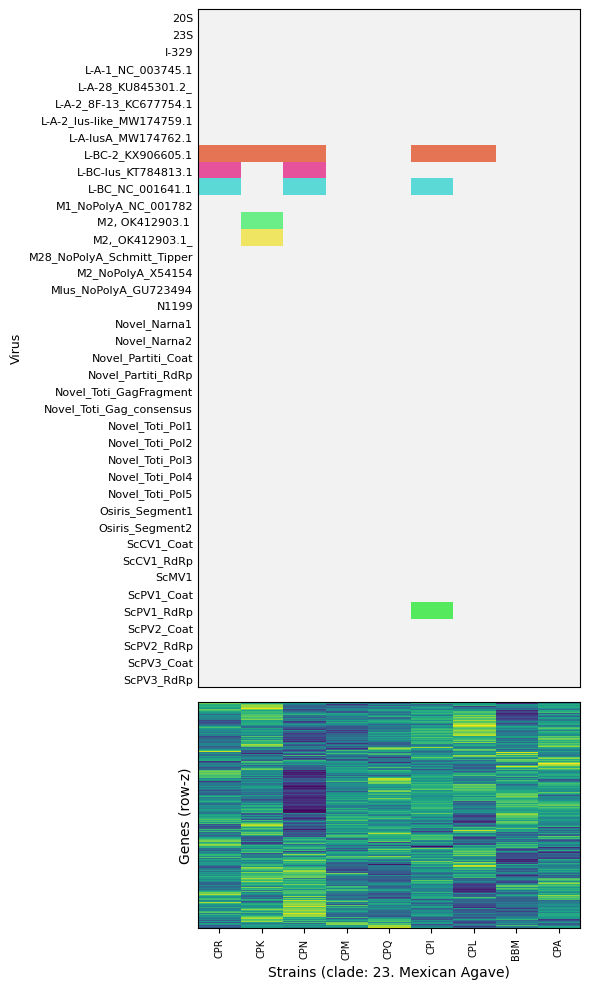

[ok] saved heatmap → data/french_guiana_heatmap.png
[ok] saved virus×strain matrix → data/french_guiana_strain_virus_matrix.csv
[info] strains in clade (23. Mexican Agave): 9


In [224]:
# --- Drop-in cell: build virus × strain map, subset French Guiana strains, and plot hierarchical heatmap ---

from pathlib import Path
import pandas as pd
import numpy as np
import gzip
import io
import re
from collections import defaultdict, OrderedDict

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_hex
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

DATA_DIR = Path("data")
META_DIR = DATA_DIR / "sample_metadata"
TARGET_CLADE = sorted(set(x.split('\n')))[16]   # <- change if you want a different clade
OUT_HEATMAP = DATA_DIR / "french_guiana_heatmap.png"
OUT_MATRIX  = DATA_DIR / "french_guiana_strain_virus_matrix.csv"

# ----------------------------
# Helpers
# ----------------------------
def _smart_read_table(path: Path):
    """Read .csv/.tsv (optionally .gz). Delimiter inferred by extension."""
    p = Path(path)
    name = p.name.lower()
    if name.endswith(".gz"):
        inner = name[:-3]
    else:
        inner = name
    if inner.endswith(".csv"):
        sep = ","
    else:
        sep = "\t"
    return pd.read_csv(p, sep=sep)

def _read_expression():
    """Load tpm_matrix.csv.gz if present, else count_matrix.csv.gz. Returns (df, kind)."""
    tpm_p = DATA_DIR / "tpm_matrix.csv.gz"
    cnt_p = DATA_DIR / "count_matrix.csv.gz"
    if tpm_p.exists():
        df = pd.read_csv(tpm_p, index_col=0)
        return df, "TPM"
    elif cnt_p.exists():
        df = pd.read_csv(cnt_p, index_col=0)
        return df, "COUNT"
    else:
        raise FileNotFoundError("Could not find tpm_matrix.csv.gz or count_matrix.csv.gz in ./data/")

def _libsize_normalize_counts(df):
    """Counts per million (CPM) normalization."""
    libsize = df.sum(axis=0).replace(0, np.nan)
    cpm = df.divide(libsize, axis=1) * 1e6
    return cpm.fillna(0.0)

def _row_zscore(df):
    mu = df.mean(axis=1)
    sd = df.std(axis=1).replace(0, np.nan)
    z = df.sub(mu, axis=0).div(sd, axis=0)
    return z.fillna(0.0)

def _log1p(df):
    return np.log1p(df)

def _pick_clade_file():
    """Find a table in ./data that contains a 'Clade' column."""
    cands = []
    for p in DATA_DIR.iterdir():
        if p.is_file() and re.search(r"\.(csv|tsv)(\.gz)?$", p.name, re.I):
            try:
                df = _smart_read_table(p)
                if "Clade" in df.columns:
                    cands.append(p)
            except Exception:
                pass
    if not cands:
        raise FileNotFoundError("No CSV/TSV in ./data contains a 'Clade' column.")
    # Prefer files whose name hints 'strain' or 'clade'
    cands = sorted(cands, key=lambda x: (not re.search(r"(strain|clade)", x.name, re.I), x.name))
    return cands[0]

def _collect_virus_maps():
    """Read every TSV in data/sample_metadata/ and build virus->set(strain)."""
    virus_to_strains = defaultdict(set)
    if META_DIR.exists():
        for p in sorted(META_DIR.glob("*.tsv")):
            df = pd.read_csv(p, sep="\t")
            # Expect columns Strain, Subpop; Subpop value 'Rest' means no infection
            need = {"Strain", "Subpop"}
            if not need.issubset(df.columns):
                continue
            sub = df[df["Subpop"].astype(str) != "Rest"].copy()
            for _, r in sub.iterrows():
                virus_to_strains[str(r["Subpop"])].add(str(r["Strain"]))
    return virus_to_strains

def _assign_colors(n, seed=7):
    rng = np.random.default_rng(seed)
    colors = []
    for _ in range(n):
        # pleasant-ish pastel palette
        h = rng.random()
        s = 0.55 + 0.15*rng.random()
        v = 0.85 + 0.10*rng.random()
        # convert HSV -> RGB manually
        i = int(h*6)
        f = h*6 - i
        p = v*(1 - s)
        q = v*(1 - f*s)
        t = v*(1 - (1-f)*s)
        i = i % 6
        if i == 0: r,g,b = v,t,p
        elif i == 1: r,g,b = q,v,p
        elif i == 2: r,g,b = p,v,t
        elif i == 3: r,g,b = p,q,v
        elif i == 4: r,g,b = t,p,v
        else: r,g,b = v,p,q
        colors.append((r,g,b))
    return [to_hex(c) for c in colors]

# ----------------------------
# Load inputs
# ----------------------------
expr_df, expr_type = _read_expression()
clade_file = _pick_clade_file()
clade_df = _smart_read_table(clade_file)
clade_strains = clade_df.loc[clade_df["Clade"].astype(str).str.strip() == TARGET_CLADE, "std_name"].astype(str).str.strip()
clade_strains = sorted(set(clade_strains))
if not clade_strains:
    raise ValueError(f"No strains found for clade: {TARGET_CLADE}")

# Intersect with expression columns
expr_strains = [s for s in clade_strains if s in expr_df.columns]
if not expr_strains:
    raise ValueError("None of the clade strains are present in the expression matrix columns.")

# Subset expression to clade strains
X = expr_df[expr_strains].copy()

# Normalize for visualization
if expr_type == "COUNT":
    Xn = _libsize_normalize_counts(X)
    viz = _row_zscore(_log1p(Xn))
else:  # TPM
    viz = _row_zscore(_log1p(X))

# Optional: keep most variable genes for clarity (top N by row variance)
TOP_N = 2000 if viz.shape[0] > 2000 else viz.shape[0]
row_var = viz.var(axis=1)
top_genes = row_var.sort_values(ascending=False).head(TOP_N).index
viz = viz.loc[top_genes]

# ----------------------------
# Virus annotations (bars)
# ----------------------------
virus_to_strains = _collect_virus_maps()
viruses = sorted([v for v in virus_to_strains.keys() if v])  # distinct virus labels
# Build virus × strain indicator matrix for our clade strains
V = pd.DataFrame(0, index=viruses, columns=expr_strains, dtype=int)
for v, sset in virus_to_strains.items():
    for s in expr_strains:
        if s in sset:
            V.loc[v, s] = 1

# Save virus-strain matrix for reference
DATA_DIR.mkdir(parents=True, exist_ok=True)
V.to_csv(OUT_MATRIX)

# ----------------------------
# Clustering
# ----------------------------
# Cluster genes and strains with correlation distance
col_link = linkage(pdist(viz.T, metric="correlation"), method="average")
row_link = linkage(pdist(viz,  metric="correlation"), method="average")
col_order = viz.columns[leaves_list(col_link)]
row_order = viz.index[leaves_list(row_link)]

viz_ord = viz.loc[row_order, col_order]
V_ord = V[col_order] if len(viruses) else V

# ----------------------------
# Plot
# ----------------------------
from matplotlib.gridspec import GridSpec

fig_w = max(6, 0.25 * viz_ord.shape[1] + 3)
fig_h = 10

if V_ord.empty:
    # No virus bars → single-row layout
    plt.figure(figsize=(fig_w, fig_h))
    gs = GridSpec(nrows=1, ncols=1)
    ax = plt.subplot(gs[0])

    ax.imshow(viz_ord.values, aspect="auto", interpolation="nearest")
    ax.set_xlabel(f"Strains (clade: {TARGET_CLADE})", fontsize=10)
    ax.set_ylabel("Genes (row-z)", fontsize=10)
    ax.set_xticks(np.arange(viz_ord.shape[1]))
    ax.set_xticklabels(viz_ord.columns, rotation=90, fontsize=7)
    ax.set_yticks([])

else:
    # With virus bars → two-row layout
    top_h = max(0.5, min(3.0, 0.18 * len(viruses)))
    plt.figure(figsize=(fig_w, fig_h))
    gs = GridSpec(nrows=2, ncols=1, height_ratios=[top_h, 1.0])

    # ---- Top: virus assignment bars
    ax_top = plt.subplot(gs[0])
    on_colors = _assign_colors(len(viruses))
    bar_img = np.zeros((len(viruses), V_ord.shape[1], 3), dtype=float)
    for i, v in enumerate(viruses):
        color_on = np.array(plt.matplotlib.colors.to_rgb(on_colors[i]))
        for j, s in enumerate(V_ord.columns):
            bar_img[i, j, :] = color_on if V_ord.loc[v, s] == 1 else (0.95, 0.95, 0.95)
    ax_top.imshow(bar_img, aspect="auto", interpolation="nearest")
    ax_top.set_yticks(np.arange(len(viruses)))
    ax_top.set_yticklabels(viruses, fontsize=8)
    ax_top.set_xticks([])
    ax_top.set_ylabel("Virus", fontsize=9)
    ax_top.tick_params(axis="y", length=0)

    # ---- Bottom: expression heatmap
    ax = plt.subplot(gs[1])
    ax.imshow(viz_ord.values, aspect="auto", interpolation="nearest")
    ax.set_xlabel(f"Strains (clade: {TARGET_CLADE})", fontsize=10)
    ax.set_ylabel("Genes (row-z)", fontsize=10)
    ax.set_xticks(np.arange(viz_ord.shape[1]))
    ax.set_xticklabels(viz_ord.columns, rotation=90, fontsize=7)
    ax.set_yticks([])

plt.tight_layout()
plt.savefig(OUT_HEATMAP, dpi=200)
plt.show()

print(f"[ok] saved heatmap → {OUT_HEATMAP}")
print(f"[ok] saved virus×strain matrix → {OUT_MATRIX}")
print(f"[info] strains in clade ({TARGET_CLADE}): {len(expr_strains)}")

In [223]:
# --- Drop-in cell: top-10 up/down expressed genes per strain (wide format) ---

OUT_SUMMARY = DATA_DIR / "french_guiana_top10_up_down_by_strain.tsv"

# 1) Expression values for ranking: TPM if available, else CPM-normalized counts
if expr_type == "TPM":
    expr_rank = expr_df[expr_strains].copy()
else:
    expr_rank = _libsize_normalize_counts(expr_df[expr_strains]).copy()  # CPM

# 2) Infection counts per strain
if 'V' not in globals() or V.empty:
    raise ValueError("Virus×strain matrix V is missing/empty; build it in the previous cell.")
infect_counts = V.sum(axis=0).reindex(expr_strains).fillna(0).astype(int)

# 3) Build summary
rows = []
for strain in expr_strains:
    s = expr_rank[strain].astype(float)

    # Top-10 upregulated
    top10_up = s.sort_values(ascending=False).head(10)
    up_str = ", ".join([f"{g}:{v:.2f}" for g, v in top10_up.items()])

    # Top-10 downregulated (lowest values)
    top10_down = s.sort_values(ascending=True).head(10)
    down_str = ", ".join([f"{g}:{v:.2f}" for g, v in top10_down.items()])

    rows.append({
        "Strain": strain,
        "Mycovirus_Infection_Count": int(infect_counts.loc[strain]),
        "Top10_Upregulated": up_str,
        "Top10_Downregulated": down_str
    })

summary_df = pd.DataFrame(rows)
summary_df.sort_values(["Mycovirus_Infection_Count", "Strain"], ascending=[False, True], inplace=True)

# 4) Bright line info for most-infected strain
if len(summary_df):
    top_strain = summary_df.iloc[0]["Strain"]
    s_top = expr_rank[top_strain].astype(float)
    top_gene = s_top.idxmax()
    top_value = float(s_top.max())
    print(f"[info] Most-infected strain: {top_strain} (viruses={int(infect_counts.loc[top_strain])})")
    print(f"[info] Highest-expression gene: {top_gene}  value={top_value:.2f} ({'TPM' if expr_type=='TPM' else 'CPM'})")

# 5) Save + preview
summary_df.to_csv(OUT_SUMMARY, sep="\t", index=False)
print(f"[ok] wrote table → {OUT_SUMMARY}")
pd.set_option("display.max_colwidth", None)  # widen column display
display(summary_df.head(20))

[info] Most-infected strain: XTRA_DHE (viruses=6)
[info] Highest-expression gene: YGR192C  value=15296.13 (TPM)
[ok] wrote table → data/french_guiana_top10_up_down_by_strain.tsv


,Strain,Mycovirus_Infection_Count,Top10_Upregulated,Top10_Downregulated
46,XTRA_DHE,6,"YGR192C:15296.13, YMR251W-A:9085.08, YLR167W:8715.40, YKL060C:8714.99, YDR524W-C:8660.06, YHR174W:8370.74, YLR110C:8118.69, YLR044C:7975.95, YBR118W:7256.40, YDR524C-B:7198.34","X1-EC1118_1F14_0012g:0.00, X504-maker.4896.BLT_2:0.00, X5-EC1118_1F14_0056g:0.00, X495-maker.3715.BPA_4:0.00, X494-maker.370.YDJ:0.00, X492-maker.348.ALB_3:0.00, X491-maker.348.ALB_3:0.00, X490-maker.348.ALB_3:0.00, X489-maker.348.ALB_3:0.00, X488-maker.3439.YAX:0.00"
45,CIE,3,"YMR251W-A:24210.20, YGR192C:14300.07, YLR110C:11657.96, YPR036W-A:11511.16, YDR524C-B:9737.12, YKL060C:8848.51, YDR524W-C:8077.49, YLR167W:7040.94, YOL109W:6883.32, YLR044C:6837.60","X1-EC1118_1F14_0012g:0.00, X646-snap_masked.4896.BLT_2:0.00, X644-snap_masked.4896.BLT_2:0.00, X641-snap_masked.4866.BCP_8:0.00, X639-snap_masked.4776.BCQ_8:0.00, X637-snap_masked.4547.CCV_1:0.00, X635-snap_masked.4313.BND_3:0.00, X628-snap_masked.4220.BCN_8:0.00, X627-snap_masked.4168.BEK_7:0.00, X626-snap_masked.3911.CCQ_1:0.00"
7,AFT,1,"YPR036W-A:14928.90, YDR524C-B:13894.88, YGR192C:11266.63, YLR110C:10127.92, YDR524W-C:9971.90, YHR162W:8971.91, YMR251W-A:8385.06, YPL187W:7730.53, YKL060C:6953.47, YLR109W:6815.15","X1-EC1118_1F14_0012g:0.00, X644-snap_masked.4896.BLT_2:0.00, X641-snap_masked.4866.BCP_8:0.00, X639-snap_masked.4776.BCQ_8:0.00, X637-snap_masked.4547.CCV_1:0.00, X635-snap_masked.4313.BND_3:0.00, X628-snap_masked.4220.BCN_8:0.00, X627-snap_masked.4168.BEK_7:0.00, X626-snap_masked.3911.CCQ_1:0.00, X625-snap_masked.3893.ATH_3:0.00"
14,AMG,1,"YMR251W-A:15626.18, YLR110C:14963.75, YGR192C:10137.13, YPR036W-A:8267.67, YDR524C-B:8066.09, YKL060C:6397.74, YKL096W-A:5930.75, YPR080W:5852.17, YDR524W-C:5645.73, YCR024C-A:5602.20","X1-EC1118_1F14_0012g:0.00, X646-snap_masked.4896.BLT_2:0.00, X644-snap_masked.4896.BLT_2:0.00, X641-snap_masked.4866.BCP_8:0.00, X639-snap_masked.4776.BCQ_8:0.00, X637-snap_masked.4547.CCV_1:0.00, X635-snap_masked.4313.BND_3:0.00, X628-snap_masked.4220.BCN_8:0.00, X627-snap_masked.4168.BEK_7:0.00, X626-snap_masked.3911.CCQ_1:0.00"
0,AAL,0,"YMR251W-A:19906.42, YGR192C:16823.22, YFL014W:11583.35, YLR110C:10512.92, YKL096W-A:9633.42, YHR174W:7974.88, YPR036W-A:7406.53, YDR524C-B:7031.64, YLR044C:6730.31, YLR109W:6725.06","X1-EC1118_1F14_0012g:0.00, X7-EC1118_1F14_0089g:0.00, X691-snap_masked.9702.ASM_8:0.00, X690-snap_masked.963.AFD_4:0.00, X688-snap_masked.9264.AVR_6:0.00, X684-snap_masked.859.BGT_2:0.00, X682-snap_masked.779.BSG_4:0.00, X678-snap_masked.7599.CPQ_4:0.00, X674-snap_masked.7473.CCL_1:0.00, X669-snap_masked.6882.YCR:0.00"
1,AAM,0,"YGR192C:12302.62, YLR110C:9728.31, YMR251W-A:8213.46, YKL060C:8038.02, YLR044C:8026.37, YPR036W-A:7404.91, YDR524W-C:7200.54, YHR174W:6886.40, YDR524C-B:6844.57, YLR167W:6188.76","X1-EC1118_1F14_0012g:0.00, X788-augustus_masked.YCM.7981:0.00, X771-augustus_masked.AKG_3.6639:0.00, X77-augustus_masked.11963.BDM_5:0.00, X76-augustus_masked.11960.BDM_5:0.00, X75-augustus_masked.11951.BDM_5:0.00, X74-augustus_masked.11951.BDM_5:0.00, X73-augustus_masked.1166.YCM:0.00, X720-augustus_masked.CFC_2.43056:0.00, X72-augustus_masked.1166.YCM:0.00"
2,AAP,0,"YMR251W-A:30367.01, YGR192C:26627.29, YFL014W:25343.24, YLR109W:15876.53, YPR036W-A:15582.97, YBR072W:14160.97, YHR174W:10934.79, YLR110C:8122.03, YKL060C:7239.15, YOL109W:7074.96","X1-EC1118_1F14_0012g:0.00, X705-augustus_masked.CFC_2.43056:0.00, X703-augustus_masked.CFC_2.43056:0.00, X70-augustus_masked.11626.ASB_2:0.00, X7-EC1118_1F14_0089g:0.00, X691-snap_masked.9702.ASM_8:0.00, X690-snap_masked.963.AFD_4:0.00, X688-snap_masked.9264.AVR_6:0.00, X684-snap_masked.859.BGT_2:0.00, X682-snap_masked.779.BSG_4:0.00"
3,ABV,0,"YMR251W-A:19940.92, YGR192C:18832.69, YLR110C:11626.03, YDR524C-B:8984.75, YKL060C:8463.59, YLR167W:7876.59, YHR174W:7782.57, YPR036W-A:7504.53, YDR524W-C:7088.39, YLR044C:7060.76","X1-EC1118_1F14_0012g:0.00, X678-snap_masked.7599.CPQ_4:0.00, X674-snap_masked.7473.CCL_1:0.00, X669-sna